In [1]:
# This notebook has everything you need to create datasets/dataloaders, create models, hyperparameter tune with optuna 
# train a model and evaluate it

In [1]:
#downsamples directly and uses and LSTM
modelType = "Baseline"

In [2]:
modelTypedict = {"Baseline": ["Downsample", "LSTM"], "ManualGRU": ["Manual", "GRU"], "ManualLSTM": ["Manual", "LSTM"], "ActiNetGRU": ["ActiNet", "GRU"], "ActiNetGRU": ["ActiNet", "LSTM"]}
acc_preprocess = modelTypedict[modelType][0]
RNN_type = modelTypedict[modelType][1]

In [3]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassCohenKappa
from IPython.display import clear_output
import optuna
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_auc_score, confusion_matrix
import seaborn as sns
from collections import Counter
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers.wandb import WandbLogger
import wandb
from x_transformers import ContinuousTransformerWrapper, Encoder
torch.set_float32_matmul_precision('medium')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
from wearables import Wearables
import time

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set up Datasets

In [4]:
data_dir = '/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz'

In [5]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.8)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.8):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

number of subjects in train: 80
number of subjects in val: 10
number of subjects in test: 10


In [6]:
non_acc_freq = 0.2
acc_freq = 32
chunk_duration = 6000 # chunk duration in seconds
chunk_stride = 3000
train_dataset_mixed = Wearables(subjects_list=subjects_train,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset_mixed)}")
val_dataset_mixed = Wearables(subjects_list=subjects_val,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq, 
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset_mixed)}")
test_dataset_mixed = Wearables(subjects_list=subjects_test,
                                 data_dir=data_dir,
                                 chunk_duration=chunk_duration,
                                 chunk_stride=chunk_stride,
                                 downsample_freq=non_acc_freq,
                                 acc_freq=acc_freq,
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset_mixed)}")

Total samples in train dataset: 202
Total samples in val dataset: 28
Total samples in test dataset: 27


In [ ]:
#OPTIONAL, save datasets as they take a long time to create
torch.save(train_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
torch.save(val_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')
torch.save(test_dataset_mixed, f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')

### Loading in and class weights

In [6]:
chunk_duration = 6000
train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/trainset_{chunk_duration}s.pt')
val_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/valset_{chunk_duration}s.pt')

/state/partition1/job-59945766/ipykernel_1009285/1658959780.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/

In [7]:
# get class weights for weighted loss
all_labels = []
for batch in DataLoader(train_dataset_mixed, batch_size=1):
    labels = batch[2].numpy()
    all_labels.extend(labels.flatten())
all_labels = np.array(all_labels)
valid_labels = all_labels[all_labels != -1]
classes = np.arange(4)
class_counts = Counter(valid_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=valid_labels
)
print(f"Class counts: {class_counts}")
print(f"Class weights: {class_weights}")

Class counts: Counter({np.int64(1): 155342, np.int64(0): 53092, np.int64(3): 24240, np.int64(2): 9372})
Class weights: [1.13974798 0.38953728 6.45662612 2.49634901]


In [8]:
weight_tensor = torch.tensor(class_weights, dtype=torch.float32)

### Model Definitions

#### Acc Models

In [9]:
#"Manual" model
def extract_features(acc, window_size=160):
    # acc: [batch_size, seq_len, 3]
    batch_size, seq_len, dims = acc.shape
    assert seq_len % window_size == 0, "seq_len must be divisible by window_size"

    # Reshape: [batch_size, seq_len // window_size, window_size, 3]
    acc = acc.view(batch_size, seq_len // window_size, window_size, dims)

    # Compute features along the window dimension (dim=2)
    mean = acc.mean(dim=2)
    abs_mean = acc.abs().mean(dim=2)
    max_val = acc.max(dim=2).values
    min_val = acc.min(dim=2).values
    range_val = max_val - min_val
    var = acc.var(dim=2, unbiased=False)
    rms = torch.sqrt((acc ** 2).mean(dim=2))
    iqr = torch.quantile(acc, 0.75, dim=2) - torch.quantile(acc, 0.25, dim=2)
    q25 = torch.quantile(acc, 0.25, dim=2)
    q50 = torch.quantile(acc, 0.50, dim=2)
    q75 = torch.quantile(acc, 0.75, dim=2)

    # Concatenate all features along the last dimension
    features = torch.cat([
        mean, abs_mean, max_val, min_val, range_val, var, rms, iqr, q25, q50, q75
    ], dim=-1)  # shape: [batch_size, seq_len // 160, 33]

    return features

In [10]:
class DeepACTINeT(nn.Module):
    def __init__(self, cnn_output_channels, dropout=0.25):
        super(DeepACTINeT, self).__init__()
        # Define the layers as per the structure provided
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=512, stride=2)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=256, stride=2)
        self.conv4 = nn.Conv1d(in_channels=16, out_channels=cnn_output_channels, kernel_size=32, stride=2)
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(16)
        self.batch_norm3 = nn.BatchNorm1d(16)
        self.batch_norm4 = nn.BatchNorm1d(cnn_output_channels)
    
    def forward(self, x):
        assert not torch.isnan(x).any(), "NaN detected in CNN input"
        print(x.shape)
        x = x.permute(0,2, 1) #flip channels and num samples [batch, ch, num samples]

        initial_samples = x.shape[2]
        #you want to end up with one every 5 seconds 
        final_samples = initial_samples // (32*5)

        x = F.relu(self.conv1(x))
        #print(f"Input shape after conv1: {x.shape}")
        x = self.dropout(x)
        #print(f"Input shape after, dropout: {x.shape}")
        x = self.batch_norm1(x)
        #print(f"Input shape after conv1,dropout,batchnorm: {x.shape}")
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.batch_norm2(x)
        #print(f"Input shape after conv2: {x.shape}")
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.batch_norm3(x)
        #print(f"Input shape after conv3: {x.shape}")
        
        x = F.max_pool1d(x, kernel_size=2, stride = 2)
        #print(f"Input shape after maxpool: {x.shape}")
        
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        x = self.batch_norm4(x)
        #print(f"before avg pooling shape: {x.shape}")

        x = F.adaptive_avg_pool1d(x, final_samples)
        #print(f"Final output shape: {x.shape}")
        
        return x

#### LSTM model 

In [11]:
#acc_preprocess = "ActiNet" or "Manual"
class SleepStager(pl.LightningModule):
    def __init__(self,
                non_acc_dim:         int,
                acc_preprocess = acc_preprocess,
                RNN_type = RNN_type,
                bidirectional = True,
                cnn_output_channels: int = 16,
                dropout_embed:   float = 0.25,
                dropout_rnn: float = 0.25,
                dropout_hidden2: float= 0.25,
                pre_rnn_embedding_size: int = 16,
                rnn_hidden_size:   int = 128,
                hidden_size2:       int = 64,
                num_sleep_stages:   int = 4,
                lr:                  float = 1e-3,
                weight_tensor:      torch.Tensor = None,
                debug:            bool = False):
        super().__init__()
        if acc_preprocess == "ActiNet":
            self.mode = "ActiNet"
            self.acc_processing = DeepACTINeT(cnn_output_channels)
            self.acc_channels = cnn_output_channels
        elif acc_preprocess == "Manual":
            self.mode = "Manual"
            self.acc_processing = extract_features
            self.acc_channels = 33
        elif acc_preprocess == "Downsample":
            self.mode = "Downsample"
            # self.acc_processing = interpolate
            self.acc_channels = 3
        else:
            raise ValueError("ActiNet or Manual or Downsample are the only valid options")
        
        self.RNN_type = RNN_type
        self.non_acc_dim = non_acc_dim
        self.embeddingLayer = nn.Linear(self.non_acc_dim, pre_rnn_embedding_size)
        self.cnn_output_channels = cnn_output_channels

        #add non linearity to the bvp and temp before lstm 
        self.pre_rnn_embedding_size = pre_rnn_embedding_size

        self.rnn_hidden_size = rnn_hidden_size
        self.hidden_size2 = hidden_size2

        self.dropout_embed = nn.Dropout(p=dropout_embed)
        self.dropout_rnn = dropout_rnn
        self.dropout_hidden2 = nn.Dropout(p=dropout_hidden2)

        self.rnn_input_size = self.pre_rnn_embedding_size + self.acc_channels
        self.rnn_hidden_size = rnn_hidden_size

        if self.RNN_type == "GRU":
            rnn = nn.GRU
        elif self.RNN_type == "LSTM":
            rnn = nn.LSTM
        else:
            raise Exception("[Error] Unknown RnnType. Currently supported: GRU, LSTM")

        self.rnn = rnn(input_size=self.rnn_input_size,
                            hidden_size=self.rnn_hidden_size,
                            dropout = self.dropout_rnn,
                            num_layers = 2,
                            bias = True,
                            batch_first=False,
                            bidirectional = True)
       
        self.hidden2 = nn.Linear(rnn_hidden_size*2, hidden_size2)
        classifier_in = hidden_size2
        self.classifier = nn.Linear(classifier_in, num_sleep_stages)
    
        self.train_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        self.val_criterion = nn.CrossEntropyLoss(weight=weight_tensor, ignore_index=-1)
        
        self.lr        = lr
        self.debug      = debug
        self.kappa = MulticlassCohenKappa(num_classes=num_sleep_stages)

    def forward(self, acc, non_acc):
        """
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        returns:
          y_hat (output_length, batch, num_sleep_stages)
        """
        # ensure ACC has a channel dim
        if acc.dim() == 2:
            acc = acc.unsqueeze(-1)          # now (batch, T, 1)
        
        # 1) ACC → CNN → (batch, num_cnn_feats, cnn_output_length)
        if self.mode == "Downsample":
            acc_feats = F.interpolate(
                acc.permute(0, 2, 1), # (batch_size, hf_input_channels, sequence_length)
                size=non_acc.shape[1],
            )
        else:
            acc_feats = self.acc_processing(acc)
        
        if self.debug:
            print(f"[DEBUG] ACC CNN output shape: {acc_feats.shape}") # (batch, num_cnn_feats, cnn_output_length)
            print(f"[DEBUG] NON_ACC input shape: {non_acc.shape}") # (batch, non_acc_length, non_acc_dim)
        
        #embed the non_acc data 
        emb_non_acc = self.embeddingLayer(non_acc)
        emb_non_acc = self.dropout_embed(emb_non_acc)
        #emb_non_acc = non_acc
        # 3) build LSTM input: (T', batch, feature_dim)
        if self.mode == "Manual":
            a = acc_feats.permute(1,0,2)
        elif self.mode == "ActiNet":
            a = acc_feats.permute(2, 0, 1)
        else:
            a = acc_feats.permute(2, 0, 1)
        b = emb_non_acc.permute(1, 0, 2)       

        if self.debug:
            print(f"[DEBUG] ACC CNN reshaped shape: {a.shape}") 
            print(f"[DEBUG] NON_ACC reshaped shape: {b.shape}")
       
        rnn_in = torch.cat([a, b], dim = 2)    # (lstm_seq_len, batch, C_cnn + D_nonacc)
        # without batch_first = true, LSTM input shape is (seq_len, batch_size, features)


        if self.debug:
            print(f"[DEBUG] RNN input shape: {rnn_in.shape}")
            print(f"[DEBUG] RNN hidden size: {self.rnn_hidden_size}")
    
        output,_ = self.rnn(rnn_in)
        output = self.hidden2(output)
        output = self.dropout_hidden2(output)
        if self.debug:
            print(f"[DEBUG] hidden2 shape: {output.shape}")
        y_hat = self.classifier(output)     # (lstm_seq_len, batch, num_sleep_stages)
        if self.debug:
            print(f"[DEBUG] Classifier output shape: {y_hat.shape}")
        return y_hat
            
    def training_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.train_criterion(y_hat_flat, labels_flat)
    
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        non_acc, acc, labels = batch
            
        '''
        non_acc: (batch, non_acc_length, non_acc_dim)
        acc:     (batch, acc_length)  or  (batch, acc_length, 1)
        labels:  (batch, non_acc_length)
        '''
        y_hat = self(acc, non_acc)            # (lstm_seq_len, batch, num_sleep_stages)
        y_hat = y_hat.permute(1, 0, 2)        # (batch, lstm_seq_len, num_sleep_stages)
    
        # flatten
        batch_size, output_length, num_sleep_stages = y_hat.shape
        y_hat_flat = y_hat.reshape(batch_size * output_length, num_sleep_stages)
        labels_flat  = labels.reshape(batch_size * output_length)
        
        # calculate loss
        loss = self.val_criterion(y_hat_flat, labels_flat)
    
        # calculate accuracy
        predictions = torch.argmax(y_hat_flat, dim=1)
        mask = labels_flat != -1
        masked_preds = predictions[mask]
        masked_labels = labels_flat[mask]
        if masked_labels.numel() > 0:
            acc = (masked_preds == masked_labels).float().mean().item()
        else:
            acc = 0.0
    
        # calculate cohen's kappa
        mask = labels_flat != -1
        y_valid = labels_flat[mask]
        preds_valid = predictions[mask]
        if y_valid.numel() > 0:
            ckappa = self.kappa.update(preds_valid, y_valid)
        else:
            ckappa = torch.tensor(0.0, device=self.device)

        # log metrics
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc",  acc,  prog_bar=True)
        
        return {"val_loss": loss, "val_acc": acc}
        
    def on_validation_epoch_end(self):
        k = self.kappa.compute()
        self.log("val_cohen_kappa", torch.nan_to_num(k,0.0), prog_bar=True)
        self.kappa.reset()
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.3, patience=3, verbose=True, min_lr=1e-6
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',  # must match your validation metric
                'interval': 'epoch',
                'frequency': 1
            }
        }


### Optuna

In [13]:
modelType

'Baseline'

In [ ]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"
def objective(trial, acc_preprocess, RNN_type, modelType):
    acc_preprocess = acc_preprocess
    RNN_type = RNN_type
    
    # Dropouts
    dropout_embed = trial.suggest_float('dropout_embed', 0.1, 0.55)
    dropout_rnn = trial.suggest_float('dropout_rnn', 0.1, 0.55)
    dropout_hidden2 = trial.suggest_float('dropout_hidden2', 0.1, 0.55)
    
    #label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.1)
    #Sizes
    pre_rnn_size = trial.suggest_categorical("pre_rnn_embedding_size", [4, 8, 16, 32, 64])
    rnn_hidden_size = trial.suggest_categorical("rnn_hidden_size", [32, 64, 128, 256, 512, 1024])
    hidden_size2 = trial.suggest_categorical("hidden_size2", [4, 8, 16, 32, 64])

    #other
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8, 16, 32, 64])
    # batch_size = trial.suggest_categorical("batch_size", [8, 16,32,64,128])

    #bidirectional = trial.suggest_categorical("bidirectional", [True, False])
    #Conditional logic for acc_preprocess-specific parameters
    if acc_preprocess == "ActiNet":
        cnn_output_channels = trial.suggest_categorical("cnn_output_channels", [8, 16, 32, 64])
        cnn_name_piece = f"_cnn{cnn_output_channels}"
    else:
        cnn_output_channels = None  # Not relevant for "Manual"
        cnn_name_piece = ""
    
    size_piece = f"prernn{pre_rnn_size}_rnn{rnn_hidden_size}_hidden{hidden_size2}"
    other_piece = f"lr{learning_rate}_batchsize{batch_size}"
    dropout_piece = f"dropoutembed{dropout_embed}_dropoutRNN{dropout_rnn}_dropouthidden2{dropout_hidden2}"
    name = size_piece+other_piece+dropout_piece+cnn_name_piece
    
    wandb_logger = WandbLogger(name, project = modelType)
    #wandb.define_metric("best_val_loss", summary="min")
    checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath=f'/scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/{trial.number}/',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
    )
    early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=True,
    mode='min'
    )
    trainer = pl.Trainer(
    max_epochs=20,
    devices=1,
    accelerator=accelerator,
    logger=wandb_logger,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=2,
    )
    model = SleepStager(non_acc_dim = 5,
                        acc_preprocess = acc_preprocess,
                        RNN_type = RNN_type,
                        dropout_embed = dropout_embed,
                        dropout_rnn = dropout_rnn,
                        dropout_hidden2 = dropout_hidden2,
                        pre_rnn_embedding_size= pre_rnn_size,
                        rnn_hidden_size= rnn_hidden_size,
                        hidden_size2= hidden_size2,
                        lr = learning_rate,
                        weight_tensor=weight_tensor.to(device),
                    debug= False)
    # train_dataset_optuna, val_dataset_optuna = get_datasets(segment_len, segment_len/2)
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = 8)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = 8)
    trainer.fit(model, train_loader, val_loader)
    

    #we will pull the best model, even if it overtrained a little, so we need to go pull that best model to understand its performance
    best_model_path = checkpoint_callback.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    best_model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = learning_rate,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    # Evaluate the best model
    trainer_best = pl.Trainer(devices=1, accelerator=accelerator)
    val_result = trainer_best.validate(best_model, val_loader, verbose=False)
    val_loss = val_result[0]["val_loss"]
    #log needed things
    wandb_logger.experiment.config.update(trial.params)
    wandb_logger.experiment.config.update({"trial_number": trial.number})
    wandb_logger.experiment.log({"best_val_loss": val_loss})
    wandb.finish()

    return val_loss

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, acc_preprocess, RNN_type, modelType), n_trials=500)
best_trial = study.best_trial
print("Best trial:")
print(f"  Value: {best_trial.value}")
print("  Params:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-29 23:27:00,174] A new study created in memory with name: no-name-8a03fae0-8acc-4d6e-b289-8cc992da709a
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 564 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 101/101 [00:05<00:00, 19.27it/s, v_num=y907, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:06<00:00, 15.51it/s, v_num=y907, train_loss_step=1.320, val_loss=1.300, val_acc=0.382, val_cohen_kappa=0.129, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.305


Epoch 1: 100%|██████████| 101/101 [00:07<00:00, 13.40it/s, v_num=y907, train_loss_step=1.360, val_loss=1.300, val_acc=0.382, val_cohen_kappa=0.129, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:09<00:00, 11.21it/s, v_num=y907, train_loss_step=1.360, val_loss=1.290, val_acc=0.379, val_cohen_kappa=0.104, train_loss_epoch=1.290]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.293


Epoch 2: 100%|██████████| 101/101 [00:05<00:00, 18.58it/s, v_num=y907, train_loss_step=1.290, val_loss=1.290, val_acc=0.379, val_cohen_kappa=0.104, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:07<00:00, 13.96it/s, v_num=y907, train_loss_step=1.290, val_loss=1.290, val_acc=0.269, val_cohen_kappa=0.102, train_loss_epoch=1.280]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.292


Epoch 3: 100%|██████████| 101/101 [00:07<00:00, 13.80it/s, v_num=y907, train_loss_step=1.240, val_loss=1.290, val_acc=0.269, val_cohen_kappa=0.102, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:05<00:00, 17.11it/s, v_num=y907, train_loss_step=1.520, val_loss=1.360, val_acc=0.269, val_cohen_kappa=0.0936, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:07<00:00, 13.88it/s, v_num=y907, train_loss_step=1.130, val_loss=1.300, val_acc=0.284, val_cohen_kappa=0.0874, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:06<00:00, 14.90it/s, v_num=y907, train_loss_step=1.320, val_loss=1.360, val_acc=0.264, val_cohen_kappa=0.0833, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 12.12it/s, v_num=y907, train_loss_step=1.320, val_loss=1.460, val_acc=0.360, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.292. Signaling Trainer to stop.


Epoch 6: 100%|██████████| 101/101 [00:08<00:00, 12.11it/s, v_num=y907, train_loss_step=1.320, val_loss=1.460, val_acc=0.360, val_cohen_kappa=0.101, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/0/best-checkpoint-v23.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 17.58it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▁
train_loss_step,▆▅▆▆▇▇▇▄▅▅▄▄▆▄▅▅▄▃▂▄▆▅▅▅▂█▅▄▁▄▄▅▇▅▇▅▃▄█▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
val_acc,██▁▁▂▁▇
val_cohen_kappa,█▄▄▃▂▁▄
val_loss,▂▁▁▄▁▄█
best_val_loss,1.2921
epoch,6
train_loss_epoch,1.22019


[I 2025-04-29 23:28:01,169] Trial 0 finished with value: 1.2920981645584106 and parameters: {'dropout_embed': 0.4339382662509974, 'dropout_rnn': 0.4494431977816371, 'dropout_hidden2': 0.4123955657279871, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 128, 'hidden_size2': 16, 'learning_rate': 0.00046006517776070466, 'batch_size': 2}. Best is trial 0 with value: 1.2920981645584106.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 138 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 54.49it/s, v_num=6n2q, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 31.58it/s, v_num=6n2q, train_loss_step=1.320, val_loss=1.360, val_acc=0.235, val_cohen_kappa=0.050, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.355


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 34.16it/s, v_num=6n2q, train_loss_step=1.420, val_loss=1.360, val_acc=0.235, val_cohen_kappa=0.050, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 35.91it/s, v_num=6n2q, train_loss_step=1.770, val_loss=1.400, val_acc=0.148, val_cohen_kappa=0.0044, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 36.65it/s, v_num=6n2q, train_loss_step=1.220, val_loss=1.370, val_acc=0.394, val_cohen_kappa=0.117, train_loss_epoch=1.340] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:04<00:00, 24.49it/s, v_num=6n2q, train_loss_step=1.220, val_loss=1.300, val_acc=0.323, val_cohen_kappa=0.103, train_loss_epoch=1.310]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.296


Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 34.71it/s, v_num=6n2q, train_loss_step=1.260, val_loss=1.300, val_acc=0.323, val_cohen_kappa=0.103, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:04<00:00, 24.28it/s, v_num=6n2q, train_loss_step=1.260, val_loss=1.270, val_acc=0.196, val_cohen_kappa=0.0887, train_loss_epoch=1.300]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 1.271


Epoch 5: 100%|██████████| 101/101 [00:02<00:00, 37.06it/s, v_num=6n2q, train_loss_step=1.230, val_loss=1.270, val_acc=0.196, val_cohen_kappa=0.0887, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:04<00:00, 24.98it/s, v_num=6n2q, train_loss_step=1.230, val_loss=1.270, val_acc=0.482, val_cohen_kappa=0.187, train_loss_epoch=1.280] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.268


Epoch 6: 100%|██████████| 101/101 [00:02<00:00, 41.90it/s, v_num=6n2q, train_loss_step=1.400, val_loss=1.270, val_acc=0.482, val_cohen_kappa=0.187, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:03<00:00, 33.56it/s, v_num=6n2q, train_loss_step=1.300, val_loss=1.380, val_acc=0.283, val_cohen_kappa=0.0952, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:04<00:00, 23.41it/s, v_num=6n2q, train_loss_step=1.300, val_loss=1.260, val_acc=0.358, val_cohen_kappa=0.134, train_loss_epoch=1.240] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.264


Epoch 8: 100%|██████████| 101/101 [00:02<00:00, 34.81it/s, v_num=6n2q, train_loss_step=1.170, val_loss=1.260, val_acc=0.358, val_cohen_kappa=0.134, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:02<00:00, 43.55it/s, v_num=6n2q, train_loss_step=1.100, val_loss=1.320, val_acc=0.305, val_cohen_kappa=0.135, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 101/101 [00:03<00:00, 27.58it/s, v_num=6n2q, train_loss_step=1.100, val_loss=1.200, val_acc=0.316, val_cohen_kappa=0.140, train_loss_epoch=1.220]

Metric val_loss improved by 0.060 >= min_delta = 0.0. New best score: 1.205


Epoch 10: 100%|██████████| 101/101 [00:02<00:00, 34.26it/s, v_num=6n2q, train_loss_step=1.150, val_loss=1.200, val_acc=0.316, val_cohen_kappa=0.140, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:03<00:00, 33.56it/s, v_num=6n2q, train_loss_step=1.200, val_loss=1.310, val_acc=0.352, val_cohen_kappa=0.0998, train_loss_epoch=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:02<00:00, 37.33it/s, v_num=6n2q, train_loss_step=1.050, val_loss=1.270, val_acc=0.302, val_cohen_kappa=0.139, train_loss_epoch=1.200] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:03<00:00, 33.49it/s, v_num=6n2q, train_loss_step=1.240, val_loss=1.300, val_acc=0.322, val_cohen_kappa=0.126, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 101/101 [00:04<00:00, 23.20it/s, v_num=6n2q, train_loss_step=1.240, val_loss=1.370, val_acc=0.3

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.205. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 101/101 [00:04<00:00, 23.16it/s, v_num=6n2q, train_loss_step=1.240, val_loss=1.370, val_acc=0.356, val_cohen_kappa=0.136, train_loss_epoch=1.170]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/1/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 28.39it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▇▆▆▅▅▄▃▃▃▂▂▁▁
train_loss_step,▅█▅▅▄▅▄▆▄▄▇▅▄▄▄▄▄▆▄▂▂▅▆▄▆▃▄▇▃▅▃▃▁▄▄▅▁▃▄▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▃▁▆▅▂█▄▅▄▅▅▄▅▅
val_cohen_kappa,▃▁▅▅▄█▄▆▆▆▅▆▆▆
val_loss,▆█▇▄▃▃▇▃▅▁▅▃▄▇
best_val_loss,1.20474
epoch,13
train_loss_epoch,1.17135


[I 2025-04-29 23:29:01,947] Trial 1 finished with value: 1.2047420740127563 and parameters: {'dropout_embed': 0.1531129606029485, 'dropout_rnn': 0.10524505272478693, 'dropout_hidden2': 0.2503727012088883, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.0061881005468469785, 'batch_size': 2}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.1 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:04<00:00,  6.34it/s, v_num=42gz, train_loss_step=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  4.90it/s, v_num=42gz, train_loss_step=1.310, val_loss=1.420, val_acc=0.547, val_cohen_kappa=0.189, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.424


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  5.08it/s, v_num=42gz, train_loss_step=1.400, val_loss=1.420, val_acc=0.547, val_cohen_kappa=0.189, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:06<00:00,  4.21it/s, v_num=42gz, train_loss_step=1.400, val_loss=1.320, val_acc=0.354, val_cohen_kappa=0.0715, train_loss_epoch=1.400]

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 1.318


Epoch 2: 100%|██████████| 26/26 [00:04<00:00,  5.32it/s, v_num=42gz, train_loss_step=1.220, val_loss=1.320, val_acc=0.354, val_cohen_kappa=0.0715, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:06<00:00,  4.29it/s, v_num=42gz, train_loss_step=1.220, val_loss=1.280, val_acc=0.253, val_cohen_kappa=0.0867, train_loss_epoch=1.340]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 1.285


Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  5.08it/s, v_num=42gz, train_loss_step=1.320, val_loss=1.280, val_acc=0.253, val_cohen_kappa=0.0867, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:04<00:00,  5.83it/s, v_num=42gz, train_loss_step=1.360, val_loss=1.300, val_acc=0.379, val_cohen_kappa=0.112, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:04<00:00,  6.03it/s, v_num=42gz, train_loss_step=1.390, val_loss=1.340, val_acc=0.156, val_cohen_kappa=0.039, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:04<00:00,  5.28it/s, v_num=42gz, train_loss_step=1.290, val_loss=1.320, val_acc=0.507, val_cohen_kappa=0.177, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:06<00:00,  4.33it/s, v_num=42gz, train_loss_step=1.290, val_loss=1.270, val_acc=0.306, val_cohen_k

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.268


Epoch 7: 100%|██████████| 26/26 [00:04<00:00,  5.35it/s, v_num=42gz, train_loss_step=1.150, val_loss=1.270, val_acc=0.306, val_cohen_kappa=0.125, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:06<00:00,  4.29it/s, v_num=42gz, train_loss_step=1.150, val_loss=1.220, val_acc=0.234, val_cohen_kappa=0.101, train_loss_epoch=1.310]

Metric val_loss improved by 0.046 >= min_delta = 0.0. New best score: 1.223


Epoch 8: 100%|██████████| 26/26 [00:04<00:00,  5.47it/s, v_num=42gz, train_loss_step=1.330, val_loss=1.220, val_acc=0.234, val_cohen_kappa=0.101, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.21it/s, v_num=42gz, train_loss_step=1.380, val_loss=1.250, val_acc=0.294, val_cohen_kappa=0.107, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:04<00:00,  5.60it/s, v_num=42gz, train_loss_step=1.130, val_loss=1.240, val_acc=0.242, val_cohen_kappa=0.126, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:04<00:00,  5.30it/s, v_num=42gz, train_loss_step=1.280, val_loss=1.240, val_acc=0.243, val_cohen_kappa=0.116, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:06<00:00,  4.29it/s, v_num=42gz, train_loss_step=1.280, val_loss=1.330, val_acc=0.214, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.223. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 26/26 [00:06<00:00,  4.29it/s, v_num=42gz, train_loss_step=1.280, val_loss=1.330, val_acc=0.214, val_cohen_kappa=0.0925, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/2/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 15.62it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,▇█▅▄▅▆▅▄▃▃▁▃
train_loss_step,▆▅▅▅▆▅▅▄▄▅▄▅▄▄▄▅▅▅▅█▅▅▄▄▅▄▄▅▃▅▄▄▄▄▄▄▃▅▁▄
trainer/global_step,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
val_acc,█▅▃▅▁▇▄▂▃▃▃▂
val_cohen_kappa,█▃▃▄▁▇▅▄▄▅▅▃
val_loss,█▄▃▄▅▄▃▁▂▂▂▅
best_val_loss,1.22276
epoch,11
train_loss_epoch,1.3016


[I 2025-04-29 23:30:17,989] Trial 2 finished with value: 1.2227600812911987 and parameters: {'dropout_embed': 0.4713909169022096, 'dropout_rnn': 0.5492459164841409, 'dropout_hidden2': 0.44131685061204995, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 256, 'hidden_size2': 8, 'learning_rate': 0.003459727590680866, 'batch_size': 8}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 192    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 151 K  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 26.06it/s, v_num=j7ty, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.97it/s, v_num=j7ty, train_loss_step=1.370, val_loss=1.350, val_acc=0.170, val_cohen_kappa=0.0545, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.348


Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.28it/s, v_num=j7ty, train_loss_step=1.340, val_loss=1.350, val_acc=0.170, val_cohen_kappa=0.0545, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s, v_num=j7ty, train_loss_step=1.340, val_loss=1.280, val_acc=0.223, val_cohen_kappa=0.0673, train_loss_epoch=1.330]

Metric val_loss improved by 0.063 >= min_delta = 0.0. New best score: 1.285


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  9.97it/s, v_num=j7ty, train_loss_step=1.330, val_loss=1.280, val_acc=0.223, val_cohen_kappa=0.0673, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  8.58it/s, v_num=j7ty, train_loss_step=1.240, val_loss=1.290, val_acc=0.253, val_cohen_kappa=0.0851, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s, v_num=j7ty, train_loss_step=1.240, val_loss=1.250, val_acc=0.259, val_cohen_kappa=0.0916, train_loss_epoch=1.250]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.249


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  8.26it/s, v_num=j7ty, train_loss_step=1.220, val_loss=1.250, val_acc=0.259, val_cohen_kappa=0.0916, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  9.85it/s, v_num=j7ty, train_loss_step=1.210, val_loss=1.270, val_acc=0.261, val_cohen_kappa=0.0971, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 13/13 [00:01<00:00, 10.08it/s, v_num=j7ty, train_loss_step=1.240, val_loss=1.290, val_acc=0.300, val_cohen_kappa=0.105, train_loss_epoch=1.230] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  9.27it/s, v_num=j7ty, train_loss_step=1.270, val_loss=1.260, val_acc=0.277, val_cohen_kappa=0.104, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.48it/s, v_num=j7ty, train_loss_step=1.270, val_loss=1.290, val_acc=0.352, val_cohen_

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.249. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 13/13 [00:02<00:00,  5.43it/s, v_num=j7ty, train_loss_step=1.270, val_loss=1.290, val_acc=0.352, val_cohen_kappa=0.106, train_loss_epoch=1.210]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/3/best-checkpoint-v18.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 30.12it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
train_loss_epoch,█▆▄▃▂▂▂▁
train_loss_step,██▇██▇▇▆▆▆▆▅▃▃▅▄▃▆▆▄▄▅▅▃▂▆▂▅▄▃▆▄▄▄▅▁▄▃▄▅
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
val_acc,▁▃▄▄▅▆▅█
val_cohen_kappa,▁▃▅▆▇███
val_loss,█▄▄▁▃▄▂▄
best_val_loss,1.2487
epoch,7
train_loss_epoch,1.20704


[I 2025-04-29 23:30:39,931] Trial 3 finished with value: 1.248695969581604 and parameters: {'dropout_embed': 0.5454003025906452, 'dropout_rnn': 0.2707725368577054, 'dropout_hidden2': 0.28329792326641134, 'pre_rnn_embedding_size': 32, 'rnn_hidden_size': 64, 'hidden_size2': 32, 'learning_rate': 0.0007087919030556449, 'batch_size': 16}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 138 K  | train
4 | hidden2         | Linear               | 516    | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 24.34it/s, v_num=6rpu, train_loss_step=1.510]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.33it/s, v_num=6rpu, train_loss_step=1.510, val_loss=1.450, val_acc=0.345, val_cohen_kappa=0.0384, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.448


Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.16it/s, v_num=6rpu, train_loss_step=1.280, val_loss=1.450, val_acc=0.345, val_cohen_kappa=0.0384, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s, v_num=6rpu, train_loss_step=1.280, val_loss=1.400, val_acc=0.296, val_cohen_kappa=0.0643, train_loss_epoch=1.380]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.396


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  8.72it/s, v_num=6rpu, train_loss_step=1.360, val_loss=1.400, val_acc=0.296, val_cohen_kappa=0.0643, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  4.82it/s, v_num=6rpu, train_loss_step=1.360, val_loss=1.390, val_acc=0.362, val_cohen_kappa=0.0921, train_loss_epoch=1.360]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.386


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  9.25it/s, v_num=6rpu, train_loss_step=1.420, val_loss=1.390, val_acc=0.362, val_cohen_kappa=0.0921, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s, v_num=6rpu, train_loss_step=1.420, val_loss=1.370, val_acc=0.355, val_cohen_kappa=0.127, train_loss_epoch=1.340] 

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 1.366


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  9.90it/s, v_num=6rpu, train_loss_step=1.410, val_loss=1.370, val_acc=0.355, val_cohen_kappa=0.127, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 13/13 [00:02<00:00,  6.23it/s, v_num=6rpu, train_loss_step=1.410, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0965, train_loss_epoch=1.330]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 1.358


Epoch 5: 100%|██████████| 13/13 [00:01<00:00, 10.05it/s, v_num=6rpu, train_loss_step=1.340, val_loss=1.360, val_acc=0.280, val_cohen_kappa=0.0965, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  6.05it/s, v_num=6rpu, train_loss_step=1.340, val_loss=1.300, val_acc=0.277, val_cohen_kappa=0.0958, train_loss_epoch=1.310]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.304


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  8.00it/s, v_num=6rpu, train_loss_step=1.210, val_loss=1.300, val_acc=0.277, val_cohen_kappa=0.0958, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s, v_num=6rpu, train_loss_step=1.400, val_loss=1.330, val_acc=0.248, val_cohen_kappa=0.0889, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  9.65it/s, v_num=6rpu, train_loss_step=1.320, val_loss=1.330, val_acc=0.269, val_cohen_kappa=0.0911, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:02<00:00,  5.78it/s, v_num=6rpu, train_loss_step=1.320, val_loss=1.280, val_acc=0.280, val_cohen_kappa=0.103, train_loss_epoch=1.300] 

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 1.284


Epoch 9: 100%|██████████| 13/13 [00:01<00:00, 10.27it/s, v_num=6rpu, train_loss_step=1.290, val_loss=1.280, val_acc=0.280, val_cohen_kappa=0.103, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:01<00:00,  9.96it/s, v_num=6rpu, train_loss_step=1.170, val_loss=1.290, val_acc=0.263, val_cohen_kappa=0.100, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s, v_num=6rpu, train_loss_step=1.170, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.117, train_loss_epoch=1.270]

Metric val_loss improved by 0.032 >= min_delta = 0.0. New best score: 1.252


Epoch 11: 100%|██████████| 13/13 [00:01<00:00,  8.23it/s, v_num=6rpu, train_loss_step=1.250, val_loss=1.250, val_acc=0.258, val_cohen_kappa=0.117, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 13/13 [00:01<00:00, 10.04it/s, v_num=6rpu, train_loss_step=1.150, val_loss=1.350, val_acc=0.220, val_cohen_kappa=0.0778, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 13/13 [00:01<00:00, 10.72it/s, v_num=6rpu, train_loss_step=1.200, val_loss=1.260, val_acc=0.319, val_cohen_kappa=0.134, train_loss_epoch=1.260] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:01<00:00,  8.73it/s, v_num=6rpu, train_loss_step=1.310, val_loss=1.350, val_acc=0.262, val_cohen_kappa=0.0974, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s, v_num=6rpu, train_loss_step=1.310, val_loss=1.290, val_acc=0.265, val_c

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.252. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s, v_num=6rpu, train_loss_step=1.310, val_loss=1.290, val_acc=0.265, val_cohen_kappa=0.0984, train_loss_epoch=1.230]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/4/best-checkpoint-v18.ckpt
Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 25.65it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
train_loss_epoch,█▇▆▅▅▄▄▄▄▃▃▂▂▂▁
train_loss_step,█▅▄▆▇▄▆▇▅▅▄▅▅▄▅▄▄▃▄▄▃▃▅▃▄▄▅▃▅▃▃▂▄▂▄▂▅▁▃▄
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_acc,▇▅██▄▄▂▃▄▃▃▁▆▃▃
val_cohen_kappa,▁▃▅▇▅▅▅▅▆▆▇▄█▅▅
val_loss,█▆▆▅▅▃▄▄▂▂▁▅▁▄▂
best_val_loss,1.25239
epoch,14
train_loss_epoch,1.23423


[I 2025-04-29 23:31:18,290] Trial 4 finished with value: 1.2523900270462036 and parameters: {'dropout_embed': 0.4136319115567111, 'dropout_rnn': 0.3746949208092797, 'dropout_hidden2': 0.3613580497461789, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 64, 'hidden_size2': 4, 'learning_rate': 0.0011937773355246394, 'batch_size': 16}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 4.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:07<00:00,  3.27it/s, v_num=rrm6, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:09<00:00,  2.77it/s, v_num=rrm6, train_loss_step=1.390, val_loss=1.360, val_acc=0.0962, val_cohen_kappa=0.0265, train_loss_epoch=1.400]

Metric val_loss improved. New best score: 1.362


Epoch 1: 100%|██████████| 26/26 [00:07<00:00,  3.30it/s, v_num=rrm6, train_loss_step=1.340, val_loss=1.360, val_acc=0.0962, val_cohen_kappa=0.0265, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:08<00:00,  2.90it/s, v_num=rrm6, train_loss_step=1.340, val_loss=1.330, val_acc=0.136, val_cohen_kappa=0.0378, train_loss_epoch=1.370] 

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.331


Epoch 2: 100%|██████████| 26/26 [00:09<00:00,  2.86it/s, v_num=rrm6, train_loss_step=1.340, val_loss=1.330, val_acc=0.136, val_cohen_kappa=0.0378, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:10<00:00,  2.49it/s, v_num=rrm6, train_loss_step=1.340, val_loss=1.330, val_acc=0.144, val_cohen_kappa=0.0531, train_loss_epoch=1.360]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.328


Epoch 3: 100%|██████████| 26/26 [00:08<00:00,  3.04it/s, v_num=rrm6, train_loss_step=1.220, val_loss=1.330, val_acc=0.144, val_cohen_kappa=0.0531, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:10<00:00,  2.59it/s, v_num=rrm6, train_loss_step=1.220, val_loss=1.320, val_acc=0.166, val_cohen_kappa=0.0764, train_loss_epoch=1.360]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 1.316


Epoch 4: 100%|██████████| 26/26 [00:08<00:00,  3.03it/s, v_num=rrm6, train_loss_step=1.380, val_loss=1.320, val_acc=0.166, val_cohen_kappa=0.0764, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:10<00:00,  2.58it/s, v_num=rrm6, train_loss_step=1.380, val_loss=1.300, val_acc=0.174, val_cohen_kappa=0.0779, train_loss_epoch=1.340]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 1.303


Epoch 5: 100%|██████████| 26/26 [00:08<00:00,  2.96it/s, v_num=rrm6, train_loss_step=1.350, val_loss=1.300, val_acc=0.174, val_cohen_kappa=0.0779, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:08<00:00,  2.91it/s, v_num=rrm6, train_loss_step=1.290, val_loss=1.340, val_acc=0.155, val_cohen_kappa=0.0511, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:08<00:00,  2.94it/s, v_num=rrm6, train_loss_step=1.480, val_loss=1.310, val_acc=0.170, val_cohen_kappa=0.0711, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:08<00:00,  3.06it/s, v_num=rrm6, train_loss_step=1.450, val_loss=1.310, val_acc=0.163, val_cohen_kappa=0.0664, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:09<00:00,  2.61it/s, v_num=rrm6, train_loss_step=1.450, val_loss=1.330, val_acc=0.176, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.303. Signaling Trainer to stop.


Epoch 8: 100%|██████████| 26/26 [00:09<00:00,  2.60it/s, v_num=rrm6, train_loss_step=1.450, val_loss=1.330, val_acc=0.176, val_cohen_kappa=0.0666, train_loss_epoch=1.300]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/5/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00,  6.86it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇███
train_loss_epoch,█▆▅▅▄▃▃▂▁
train_loss_step,▇▆▆▅▄▅▅▅▅▅▄▅▄▅▅▆▄▁▃▃▃▅▅▃▂▆▅▄▁▄▃▅▂▃█▅▆▃▃▇
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇████
val_acc,▁▄▅▇█▆█▇█
val_cohen_kappa,▁▃▅██▄▇▆▆
val_loss,█▄▄▃▁▆▂▂▅
best_val_loss,1.30276
epoch,8
train_loss_epoch,1.30189


[I 2025-04-29 23:32:54,335] Trial 5 finished with value: 1.3027628660202026 and parameters: {'dropout_embed': 0.5032923660324129, 'dropout_rnn': 0.3179038965679448, 'dropout_hidden2': 0.10353708313228051, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 4, 'learning_rate': 0.00016839306018642973, 'batch_size': 8}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=57vj, train_loss_step=1.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:05<00:00,  0.74it/s, v_num=57vj, train_loss_step=1.550, val_loss=1.370, val_acc=0.358, val_cohen_kappa=0.122, train_loss_epoch=1.380]

Metric val_loss improved. New best score: 1.372


Epoch 1: 100%|██████████| 4/4 [00:04<00:00,  0.84it/s, v_num=57vj, train_loss_step=1.350, val_loss=1.370, val_acc=0.358, val_cohen_kappa=0.122, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:05<00:00,  0.69it/s, v_num=57vj, train_loss_step=1.350, val_loss=1.350, val_acc=0.282, val_cohen_kappa=0.0552, train_loss_epoch=1.360]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.349


Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=57vj, train_loss_step=1.400, val_loss=1.350, val_acc=0.282, val_cohen_kappa=0.0552, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:04<00:00,  0.88it/s, v_num=57vj, train_loss_step=1.400, val_loss=1.320, val_acc=0.248, val_cohen_kappa=0.0811, train_loss_epoch=1.350]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 1.318


Epoch 3: 100%|██████████| 4/4 [00:04<00:00,  0.92it/s, v_num=57vj, train_loss_step=1.380, val_loss=1.320, val_acc=0.248, val_cohen_kappa=0.0811, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:05<00:00,  0.75it/s, v_num=57vj, train_loss_step=1.380, val_loss=1.300, val_acc=0.223, val_cohen_kappa=0.0922, train_loss_epoch=1.330]

Metric val_loss improved by 0.017 >= min_delta = 0.0. New best score: 1.301


Epoch 4: 100%|██████████| 4/4 [00:05<00:00,  0.77it/s, v_num=57vj, train_loss_step=1.230, val_loss=1.300, val_acc=0.223, val_cohen_kappa=0.0922, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=57vj, train_loss_step=1.250, val_loss=1.390, val_acc=0.145, val_cohen_kappa=0.0369, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:05<00:00,  0.75it/s, v_num=57vj, train_loss_step=1.250, val_loss=1.300, val_acc=0.242, val_cohen_kappa=0.0933, train_loss_epoch=1.330]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.298


Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s, v_num=57vj, train_loss_step=1.430, val_loss=1.300, val_acc=0.242, val_cohen_kappa=0.0933, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:05<00:00,  0.80it/s, v_num=57vj, train_loss_step=1.430, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.110, train_loss_epoch=1.310] 

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.271


Epoch 7: 100%|██████████| 4/4 [00:05<00:00,  0.80it/s, v_num=57vj, train_loss_step=1.300, val_loss=1.270, val_acc=0.269, val_cohen_kappa=0.110, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=57vj, train_loss_step=1.360, val_loss=1.370, val_acc=0.319, val_cohen_kappa=0.113, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=57vj, train_loss_step=1.360, val_loss=1.340, val_acc=0.256, val_cohen_kappa=0.0801, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:04<00:00,  0.85it/s, v_num=57vj, train_loss_step=1.340, val_loss=1.320, val_acc=0.198, val_cohen_kappa=0.0661, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:05<00:00,  0.68it/s, v_num=57vj, train_loss_step=1.340, val_loss=1.270, val_acc=0.222, val_cohen_kappa=0.1

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.267


Epoch 11: 100%|██████████| 4/4 [00:05<00:00,  0.75it/s, v_num=57vj, train_loss_step=1.240, val_loss=1.270, val_acc=0.222, val_cohen_kappa=0.102, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s, v_num=57vj, train_loss_step=1.210, val_loss=1.310, val_acc=0.211, val_cohen_kappa=0.0859, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:04<00:00,  0.93it/s, v_num=57vj, train_loss_step=1.310, val_loss=1.440, val_acc=0.242, val_cohen_kappa=0.0693, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s, v_num=57vj, train_loss_step=1.320, val_loss=1.350, val_acc=0.226, val_cohen_kappa=0.0803, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=57vj, train_loss_step=1.320, val_loss=1.350, val_acc=0.201, val_cohen_kappa

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.267. Signaling Trainer to stop.


Epoch 14: 100%|██████████| 4/4 [00:04<00:00,  0.87it/s, v_num=57vj, train_loss_step=1.320, val_loss=1.350, val_acc=0.201, val_cohen_kappa=0.0746, train_loss_epoch=1.270]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/6/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇███
train_loss_epoch,█▇▆▅▄▅▄▃▄▃▂▁▃▁▂
train_loss_step,▅█▅▄▄▅▄▅▃▂▄▂▃▆▃▃▃▄▃▄▂▄▃▂▃▁▂▃▂▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,█▆▄▄▁▄▅▇▅▃▄▃▄▄▃
val_cohen_kappa,█▃▅▆▁▆▇▇▅▃▆▅▄▅▄
val_loss,▅▄▃▂▆▂▁▅▄▃▁▃█▄▄
best_val_loss,1.26663
epoch,14
train_loss_epoch,1.27049


[I 2025-04-29 23:34:22,686] Trial 6 finished with value: 1.2666295766830444 and parameters: {'dropout_embed': 0.5436083209012667, 'dropout_rnn': 0.2511431620096437, 'dropout_hidden2': 0.3243466441867762, 'pre_rnn_embedding_size': 8, 'rnn_hidden_size': 512, 'hidden_size2': 8, 'learning_rate': 0.0024445634202143584, 'batch_size': 64}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.1 M  | train
4 | hidden2         | Linear               | 8.2 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 26/26 [00:04<00:00,  6.26it/s, v_num=wuot, train_loss_step=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 26/26 [00:05<00:00,  4.86it/s, v_num=wuot, train_loss_step=1.390, val_loss=1.380, val_acc=0.108, val_cohen_kappa=0.0161, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.382


Epoch 1: 100%|██████████| 26/26 [00:05<00:00,  4.99it/s, v_num=wuot, train_loss_step=1.370, val_loss=1.380, val_acc=0.108, val_cohen_kappa=0.0161, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 26/26 [00:06<00:00,  4.06it/s, v_num=wuot, train_loss_step=1.370, val_loss=1.380, val_acc=0.241, val_cohen_kappa=0.0755, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.381


Epoch 2: 100%|██████████| 26/26 [00:05<00:00,  5.09it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.380, val_acc=0.241, val_cohen_kappa=0.0755, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 26/26 [00:06<00:00,  4.18it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.380, val_acc=0.384, val_cohen_kappa=0.0951, train_loss_epoch=1.380]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.380


Epoch 3: 100%|██████████| 26/26 [00:05<00:00,  5.07it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.380, val_acc=0.384, val_cohen_kappa=0.0951, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 26/26 [00:06<00:00,  4.06it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.380, val_acc=0.372, val_cohen_kappa=0.0997, train_loss_epoch=1.370]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.377


Epoch 4: 100%|██████████| 26/26 [00:05<00:00,  5.14it/s, v_num=wuot, train_loss_step=1.360, val_loss=1.380, val_acc=0.372, val_cohen_kappa=0.0997, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 26/26 [00:06<00:00,  4.06it/s, v_num=wuot, train_loss_step=1.360, val_loss=1.370, val_acc=0.385, val_cohen_kappa=0.112, train_loss_epoch=1.360] 

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.372


Epoch 5: 100%|██████████| 26/26 [00:04<00:00,  5.26it/s, v_num=wuot, train_loss_step=1.250, val_loss=1.370, val_acc=0.385, val_cohen_kappa=0.112, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 26/26 [00:06<00:00,  4.21it/s, v_num=wuot, train_loss_step=1.250, val_loss=1.370, val_acc=0.365, val_cohen_kappa=0.114, train_loss_epoch=1.350]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.369


Epoch 6: 100%|██████████| 26/26 [00:04<00:00,  5.35it/s, v_num=wuot, train_loss_step=1.360, val_loss=1.370, val_acc=0.365, val_cohen_kappa=0.114, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 26/26 [00:06<00:00,  4.31it/s, v_num=wuot, train_loss_step=1.360, val_loss=1.350, val_acc=0.279, val_cohen_kappa=0.0963, train_loss_epoch=1.320]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.348


Epoch 7: 100%|██████████| 26/26 [00:04<00:00,  6.23it/s, v_num=wuot, train_loss_step=1.220, val_loss=1.350, val_acc=0.279, val_cohen_kappa=0.0963, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 26/26 [00:05<00:00,  4.86it/s, v_num=wuot, train_loss_step=1.220, val_loss=1.310, val_acc=0.270, val_cohen_kappa=0.0859, train_loss_epoch=1.310]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.310


Epoch 8: 100%|██████████| 26/26 [00:05<00:00,  4.96it/s, v_num=wuot, train_loss_step=1.270, val_loss=1.310, val_acc=0.270, val_cohen_kappa=0.0859, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 26/26 [00:06<00:00,  4.02it/s, v_num=wuot, train_loss_step=1.270, val_loss=1.280, val_acc=0.294, val_cohen_kappa=0.123, train_loss_epoch=1.300] 

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.282


Epoch 9: 100%|██████████| 26/26 [00:04<00:00,  5.21it/s, v_num=wuot, train_loss_step=1.200, val_loss=1.280, val_acc=0.294, val_cohen_kappa=0.123, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 26/26 [00:06<00:00,  4.17it/s, v_num=wuot, train_loss_step=1.200, val_loss=1.280, val_acc=0.276, val_cohen_kappa=0.117, train_loss_epoch=1.290]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.278


Epoch 10: 100%|██████████| 26/26 [00:05<00:00,  5.20it/s, v_num=wuot, train_loss_step=1.310, val_loss=1.280, val_acc=0.276, val_cohen_kappa=0.117, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 26/26 [00:06<00:00,  4.16it/s, v_num=wuot, train_loss_step=1.310, val_loss=1.260, val_acc=0.270, val_cohen_kappa=0.118, train_loss_epoch=1.290]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 1.256


Epoch 11: 100%|██████████| 26/26 [00:05<00:00,  5.16it/s, v_num=wuot, train_loss_step=1.520, val_loss=1.260, val_acc=0.270, val_cohen_kappa=0.118, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 26/26 [00:06<00:00,  4.10it/s, v_num=wuot, train_loss_step=1.520, val_loss=1.250, val_acc=0.256, val_cohen_kappa=0.117, train_loss_epoch=1.270]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.253


Epoch 12: 100%|██████████| 26/26 [00:05<00:00,  5.11it/s, v_num=wuot, train_loss_step=1.360, val_loss=1.250, val_acc=0.256, val_cohen_kappa=0.117, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:05<00:00,  5.19it/s, v_num=wuot, train_loss_step=1.260, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.112, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 26/26 [00:06<00:00,  4.09it/s, v_num=wuot, train_loss_step=1.260, val_loss=1.250, val_acc=0.245, val_cohen_kappa=0.108, train_loss_epoch=1.270]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.252


Epoch 14: 100%|██████████| 26/26 [00:04<00:00,  5.26it/s, v_num=wuot, train_loss_step=1.410, val_loss=1.250, val_acc=0.245, val_cohen_kappa=0.108, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:04<00:00,  5.28it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.260, val_acc=0.257, val_cohen_kappa=0.106, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 26/26 [00:06<00:00,  4.06it/s, v_num=wuot, train_loss_step=1.380, val_loss=1.250, val_acc=0.278, val_cohen_kappa=0.124, train_loss_epoch=1.250]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.251


Epoch 16: 100%|██████████| 26/26 [00:04<00:00,  5.36it/s, v_num=wuot, train_loss_step=1.330, val_loss=1.250, val_acc=0.278, val_cohen_kappa=0.124, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 26/26 [00:06<00:00,  4.25it/s, v_num=wuot, train_loss_step=1.330, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.105, train_loss_epoch=1.250]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.248


Epoch 17: 100%|██████████| 26/26 [00:04<00:00,  5.21it/s, v_num=wuot, train_loss_step=1.190, val_loss=1.250, val_acc=0.251, val_cohen_kappa=0.105, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 26/26 [00:05<00:00,  5.17it/s, v_num=wuot, train_loss_step=1.200, val_loss=1.250, val_acc=0.237, val_cohen_kappa=0.0959, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 26/26 [00:06<00:00,  4.18it/s, v_num=wuot, train_loss_step=1.200, val_loss=1.240, val_acc=0.261, val_cohen_kappa=0.114, train_loss_epoch=1.240] 

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.241


Epoch 19: 100%|██████████| 26/26 [00:05<00:00,  5.20it/s, v_num=wuot, train_loss_step=1.090, val_loss=1.240, val_acc=0.261, val_cohen_kappa=0.114, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 26/26 [00:06<00:00,  4.12it/s, v_num=wuot, train_loss_step=1.090, val_loss=1.250, val_acc=0.252, val_cohen_kappa=0.103, train_loss_epoch=1.240]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 26/26 [00:06<00:00,  4.12it/s, v_num=wuot, train_loss_step=1.090, val_loss=1.250, val_acc=0.252, val_cohen_kappa=0.103, train_loss_epoch=1.240]


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/7/best-checkpoint-v18.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 4/4 [00:00<00:00, 19.82it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss_epoch,███▇▇▆▅▄▄▃▃▂▃▂▂▂▁▁▁▁
train_loss_step,██████▇▇▇▇▆▅▆▆▇▅▆▅▅▄▇▅▇▁▆█▇▃▂▅▇▅▅▆▇▃▄▅▆▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
val_acc,▁▄████▅▅▆▅▅▅▅▄▅▅▅▄▅▅
val_cohen_kappa,▁▅▆▆▇▇▆▆████▇▇▇█▇▆▇▇
val_loss,█████▇▆▄▃▃▂▂▂▂▂▂▁▁▁▂
best_val_loss,1.24063
epoch,19
train_loss_epoch,1.23734


[I 2025-04-29 23:36:33,095] Trial 7 finished with value: 1.2406257390975952 and parameters: {'dropout_embed': 0.5048895242843134, 'dropout_rnn': 0.5381220470526296, 'dropout_hidden2': 0.17523916286937402, 'pre_rnn_embedding_size': 4, 'rnn_hidden_size': 256, 'hidden_size2': 16, 'learning_rate': 5.5508929266907494e-05, 'batch_size': 8}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 142 K  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 68     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 25.86it/s, v_num=aysh, train_loss_step=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 13/13 [00:01<00:00,  9.13it/s, v_num=aysh, train_loss_step=1.380, val_loss=1.400, val_acc=0.256, val_cohen_kappa=0.0209, train_loss_epoch=1.390]

Metric val_loss improved. New best score: 1.401


Epoch 1: 100%|██████████| 13/13 [00:01<00:00, 10.13it/s, v_num=aysh, train_loss_step=1.370, val_loss=1.400, val_acc=0.256, val_cohen_kappa=0.0209, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 13/13 [00:02<00:00,  5.75it/s, v_num=aysh, train_loss_step=1.370, val_loss=1.370, val_acc=0.217, val_cohen_kappa=0.0504, train_loss_epoch=1.360]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 1.366


Epoch 2: 100%|██████████| 13/13 [00:01<00:00,  9.83it/s, v_num=aysh, train_loss_step=1.280, val_loss=1.370, val_acc=0.217, val_cohen_kappa=0.0504, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 13/13 [00:02<00:00,  5.69it/s, v_num=aysh, train_loss_step=1.280, val_loss=1.330, val_acc=0.181, val_cohen_kappa=0.0583, train_loss_epoch=1.320]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.330


Epoch 3: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s, v_num=aysh, train_loss_step=1.250, val_loss=1.330, val_acc=0.181, val_cohen_kappa=0.0583, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 13/13 [00:02<00:00,  5.59it/s, v_num=aysh, train_loss_step=1.250, val_loss=1.300, val_acc=0.197, val_cohen_kappa=0.0749, train_loss_epoch=1.270]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.302


Epoch 4: 100%|██████████| 13/13 [00:01<00:00,  9.54it/s, v_num=aysh, train_loss_step=1.240, val_loss=1.300, val_acc=0.197, val_cohen_kappa=0.0749, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:01<00:00,  9.68it/s, v_num=aysh, train_loss_step=1.290, val_loss=1.310, val_acc=0.252, val_cohen_kappa=0.0771, train_loss_epoch=1.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 13/13 [00:02<00:00,  5.79it/s, v_num=aysh, train_loss_step=1.290, val_loss=1.270, val_acc=0.240, val_cohen_kappa=0.0729, train_loss_epoch=1.250]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.275


Epoch 6: 100%|██████████| 13/13 [00:01<00:00,  9.81it/s, v_num=aysh, train_loss_step=1.320, val_loss=1.270, val_acc=0.240, val_cohen_kappa=0.0729, train_loss_epoch=1.250]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 13/13 [00:01<00:00,  8.13it/s, v_num=aysh, train_loss_step=1.330, val_loss=1.300, val_acc=0.226, val_cohen_kappa=0.072, train_loss_epoch=1.240] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 13/13 [00:01<00:00,  8.19it/s, v_num=aysh, train_loss_step=1.140, val_loss=1.340, val_acc=0.270, val_cohen_kappa=0.0701, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:01<00:00, 10.22it/s, v_num=aysh, train_loss_step=1.200, val_loss=1.340, val_acc=0.220, val_cohen_kappa=0.0727, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s, v_num=aysh, train_loss_step=1.200, val_loss=1.340, val_acc=0.266, val_cohen

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.275. Signaling Trainer to stop.


Epoch 9: 100%|██████████| 13/13 [00:02<00:00,  5.84it/s, v_num=aysh, train_loss_step=1.200, val_loss=1.340, val_acc=0.266, val_cohen_kappa=0.0722, train_loss_epoch=1.220]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/8/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 23.15it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇███
train_loss_epoch,█▇▅▃▃▂▂▂▁▁
train_loss_step,██▇██▆▇▆█▇▇▆▄▆▅▅▅▆▃▆▇▇▄▃▁▆▁▅▂▄▂▃▂▂▆▄▃▄▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████
val_acc,▇▄▁▂▇▆▅█▄█
val_cohen_kappa,▁▅▆██▇▇▇▇▇
val_loss,█▆▄▃▃▁▃▅▄▄
best_val_loss,1.27495
epoch,9
train_loss_epoch,1.21795


[I 2025-04-29 23:36:59,792] Trial 8 finished with value: 1.2749487161636353 and parameters: {'dropout_embed': 0.3816103842622691, 'dropout_rnn': 0.3197011186104653, 'dropout_hidden2': 0.27580911056742374, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 64, 'hidden_size2': 16, 'learning_rate': 0.0007083482372659089, 'batch_size': 16}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 96     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 2.1 M  | train
4 | hidden2         | Linear               | 2.1 K  | train
5 | classifier      | Linear               | 20     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | 

Epoch 0: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s, v_num=x4xx, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, v_num=x4xx, train_loss_step=1.320, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved. New best score: 1.461


Epoch 1: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.459


Epoch 2: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s, v_num=x4xx, train_loss_step=1.350, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s, v_num=x4xx, train_loss_step=1.350, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.458


Epoch 3: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=x4xx, train_loss_step=1.430, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, v_num=x4xx, train_loss_step=1.430, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.456


Epoch 4: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s, v_num=x4xx, train_loss_step=1.310, val_loss=1.460, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s, v_num=x4xx, train_loss_step=1.310, val_loss=1.450, val_acc=0.209, val_cohen_kappa=0.00133, train_loss_epoch=1.410]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.453


Epoch 5: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=x4xx, train_loss_step=1.490, val_loss=1.450, val_acc=0.209, val_cohen_kappa=0.00133, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, v_num=x4xx, train_loss_step=1.490, val_loss=1.450, val_acc=0.209, val_cohen_kappa=0.00695, train_loss_epoch=1.410]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.451


Epoch 6: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.450, val_acc=0.209, val_cohen_kappa=0.00695, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.450, val_acc=0.208, val_cohen_kappa=0.0139, train_loss_epoch=1.400] 

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.449


Epoch 7: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.450, val_acc=0.208, val_cohen_kappa=0.0139, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.450, val_acc=0.208, val_cohen_kappa=0.0183, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.446


Epoch 8: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=x4xx, train_loss_step=1.320, val_loss=1.450, val_acc=0.208, val_cohen_kappa=0.0183, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=x4xx, train_loss_step=1.320, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0196, train_loss_epoch=1.400]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.443


Epoch 9: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=x4xx, train_loss_step=1.360, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0196, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=x4xx, train_loss_step=1.360, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0203, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.442


Epoch 10: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0203, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.440, val_acc=0.204, val_cohen_kappa=0.0223, train_loss_epoch=1.400]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.439


Epoch 11: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s, v_num=x4xx, train_loss_step=1.420, val_loss=1.440, val_acc=0.204, val_cohen_kappa=0.0223, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s, v_num=x4xx, train_loss_step=1.420, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0252, train_loss_epoch=1.400]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.436


Epoch 12: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s, v_num=x4xx, train_loss_step=1.440, val_loss=1.440, val_acc=0.205, val_cohen_kappa=0.0252, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=x4xx, train_loss_step=1.440, val_loss=1.430, val_acc=0.204, val_cohen_kappa=0.0276, train_loss_epoch=1.400]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.433


Epoch 13: 100%|██████████| 4/4 [00:02<00:00,  1.69it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.430, val_acc=0.204, val_cohen_kappa=0.0276, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s, v_num=x4xx, train_loss_step=1.390, val_loss=1.430, val_acc=0.200, val_cohen_kappa=0.0283, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.428


Epoch 14: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s, v_num=x4xx, train_loss_step=1.330, val_loss=1.430, val_acc=0.200, val_cohen_kappa=0.0283, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s, v_num=x4xx, train_loss_step=1.330, val_loss=1.420, val_acc=0.201, val_cohen_kappa=0.0289, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.425


Epoch 15: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.420, val_acc=0.201, val_cohen_kappa=0.0289, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=x4xx, train_loss_step=1.380, val_loss=1.420, val_acc=0.201, val_cohen_kappa=0.0306, train_loss_epoch=1.390]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.421


Epoch 16: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s, v_num=x4xx, train_loss_step=1.330, val_loss=1.420, val_acc=0.201, val_cohen_kappa=0.0306, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=x4xx, train_loss_step=1.330, val_loss=1.420, val_acc=0.199, val_cohen_kappa=0.0319, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.417


Epoch 17: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s, v_num=x4xx, train_loss_step=1.400, val_loss=1.420, val_acc=0.199, val_cohen_kappa=0.0319, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s, v_num=x4xx, train_loss_step=1.400, val_loss=1.410, val_acc=0.197, val_cohen_kappa=0.0316, train_loss_epoch=1.390]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.412


Epoch 18: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s, v_num=x4xx, train_loss_step=1.320, val_loss=1.410, val_acc=0.197, val_cohen_kappa=0.0316, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s, v_num=x4xx, train_loss_step=1.320, val_loss=1.410, val_acc=0.195, val_cohen_kappa=0.0335, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.405


Epoch 19: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s, v_num=x4xx, train_loss_step=1.420, val_loss=1.410, val_acc=0.195, val_cohen_kappa=0.0335, train_loss_epoch=1.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s, v_num=x4xx, train_loss_step=1.420, val_loss=1.400, val_acc=0.195, val_cohen_kappa=0.0384, train_loss_epoch=1.380]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.398
`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, v_num=x4xx, train_loss_step=1.420, val_loss=1.400, val_acc=0.195, val_cohen_kappa=0.0384, train_loss_epoch=1.380]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/9/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss_epoch,█▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▂▁
train_loss_step,▅▁▅▄▆▂▄▆▄▁▄█▅▄▅▄▅▁▅▃▄▄▅▅▃▆▅▄▅▂▃▄▄▂▅▄▄▁▄▅
trainer/global_step,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,███████▇▆▆▆▆▆▄▄▄▃▂▁▁
val_cohen_kappa,▁▁▁▁▁▂▄▄▅▅▅▆▆▆▆▇▇▇▇█
val_loss,███▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▂▁
best_val_loss,1.39821
epoch,19
train_loss_epoch,1.38124


[I 2025-04-29 23:38:10,218] Trial 9 finished with value: 1.398207426071167 and parameters: {'dropout_embed': 0.5207994972869551, 'dropout_rnn': 0.1944227688411284, 'dropout_hidden2': 0.1838498739963927, 'pre_rnn_embedding_size': 16, 'rnn_hidden_size': 256, 'hidden_size2': 4, 'learning_rate': 5.4316857815769047e-05, 'batch_size': 64}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 34.1 M | train
4 | hidden2         | Linear               | 131 K  | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 101/101 [01:02<00:00,  1.63it/s, v_num=bfep, train_loss_step=nan.0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [01:08<00:00,  1.47it/s, v_num=bfep, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]

Monitored metric val_loss = nan is not finite. Previous best value was inf. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 101/101 [01:10<00:00,  1.44it/s, v_num=bfep, train_loss_step=nan.0, val_loss=nan.0, val_acc=0.208, val_cohen_kappa=0.000, train_loss_epoch=nan.0]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/10/best-checkpoint-v18.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:04<00:00,  2.94it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,▁█
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁
val_cohen_kappa,▁
best_val_loss,nan
epoch,0
train_loss_epoch,nan
train_loss_step,nan
trainer/global_step,100
val_acc,0.20848


[W 2025-04-29 23:39:31,678] Trial 10 failed with parameters: {'dropout_embed': 0.12916400206572898, 'dropout_rnn': 0.14359436044100035, 'dropout_hidden2': 0.5105784822945836, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 1024, 'hidden_size2': 64, 'learning_rate': 0.009499380781497826, 'batch_size': 2} because of the following error: The value nan is not acceptable.
[W 2025-04-29 23:39:31,679] Trial 10 failed with value nan.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 384    | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 50.9 K | train
4 | hidden2         | Linear               | 4.2 K  | train
5 | classifier      | Linear               | 260    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 101/101 [00:01<00:00, 50.97it/s, v_num=efvp, train_loss_step=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:03<00:00, 33.04it/s, v_num=efvp, train_loss_step=1.100, val_loss=1.340, val_acc=0.230, val_cohen_kappa=0.0584, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.339


Epoch 1: 100%|██████████| 101/101 [00:02<00:00, 37.77it/s, v_num=efvp, train_loss_step=1.320, val_loss=1.340, val_acc=0.230, val_cohen_kappa=0.0584, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:02<00:00, 37.93it/s, v_num=efvp, train_loss_step=1.040, val_loss=1.360, val_acc=0.164, val_cohen_kappa=0.021, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:02<00:00, 41.71it/s, v_num=efvp, train_loss_step=1.210, val_loss=1.400, val_acc=0.257, val_cohen_kappa=0.0751, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:02<00:00, 36.29it/s, v_num=efvp, train_loss_step=1.460, val_loss=1.350, val_acc=0.536, val_cohen_kappa=0.128, train_loss_epoch=1.310] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 26.57it/s, v_num=efvp, train_loss_step=1.460, val_loss=1.440, val_acc=0.348,

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.339. Signaling Trainer to stop.


Epoch 4: 100%|██████████| 101/101 [00:03<00:00, 26.51it/s, v_num=efvp, train_loss_step=1.460, val_loss=1.440, val_acc=0.348, val_cohen_kappa=0.110, train_loss_epoch=1.270]
Best model path: /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/11/best-checkpoint-v17.ckpt


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation DataLoader 0: 100%|██████████| 14/14 [00:00<00:00, 34.25it/s]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


best_val_loss,▁
epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▆▆▆███████████
train_loss_epoch,█▅▄▄▁
train_loss_step,▄▅▇▅▅▅▄▄▅▄▂▂▄▅▄▃▄▅▄▅▄▂▅▃▂▂▄▄▁▄▆▃▂▃▅▄▃▄▆█
trainer/global_step,▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇███
val_acc,▂▁▃█▄
val_cohen_kappa,▃▁▅█▇
val_loss,▁▃▅▁█
best_val_loss,1.33922
epoch,4
train_loss_epoch,1.26794


[I 2025-04-29 23:39:54,775] Trial 11 finished with value: 1.3392200469970703 and parameters: {'dropout_embed': 0.11770524401924032, 'dropout_rnn': 0.12065053357333444, 'dropout_hidden2': 0.5351828654099343, 'pre_rnn_embedding_size': 64, 'rnn_hidden_size': 32, 'hidden_size2': 64, 'learning_rate': 0.007845146565455376, 'batch_size': 2}. Best is trial 1 with value: 1.2047420740127563.
/state/partition1/job-59918280/ipykernel_522356/1335623980.py:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/moved_from_home/checkpoints/12 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 24     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 33.6 M | train
4 | hidden2         | Linear               | 16.4 K | train
5 | classifier      | Linear               | 36     | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 |

Epoch 0: 100%|██████████| 51/51 [00:35<00:00,  1.43it/s, v_num=19nx, train_loss_step=1.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s, v_num=19nx, train_loss_step=1.520, val_loss=1.480, val_acc=0.209, val_cohen_kappa=-1.24e-5, train_loss_epoch=1.990]

Metric val_loss improved. New best score: 1.475


Epoch 1: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s, v_num=19nx, train_loss_step=1.380, val_loss=1.480, val_acc=0.209, val_cohen_kappa=-1.24e-5, train_loss_epoch=1.990]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 51/51 [00:40<00:00,  1.26it/s, v_num=19nx, train_loss_step=1.380, val_loss=1.420, val_acc=0.136, val_cohen_kappa=0.00697, train_loss_epoch=1.480] 

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.423


Epoch 2: 100%|██████████| 51/51 [00:34<00:00,  1.50it/s, v_num=19nx, train_loss_step=1.730, val_loss=1.420, val_acc=0.136, val_cohen_kappa=0.00697, train_loss_epoch=1.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s, v_num=19nx, train_loss_step=1.350, val_loss=1.440, val_acc=0.372, val_cohen_kappa=0.0284, train_loss_epoch=1.400] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s, v_num=19nx, train_loss_step=1.350, val_loss=1.390, val_acc=0.450, val_cohen_kappa=-0.00118, train_loss_epoch=1.390]

Metric val_loss improved by 0.038 >= min_delta = 0.0. New best score: 1.386


Epoch 4: 100%|██████████| 51/51 [00:36<00:00,  1.40it/s, v_num=19nx, train_loss_step=1.420, val_loss=1.390, val_acc=0.450, val_cohen_kappa=-0.00118, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 51/51 [00:40<00:00,  1.27it/s, v_num=19nx, train_loss_step=1.420, val_loss=1.380, val_acc=0.382, val_cohen_kappa=0.0493, train_loss_epoch=1.390]  

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 1.383


Epoch 5: 100%|██████████| 51/51 [00:33<00:00,  1.52it/s, v_num=19nx, train_loss_step=1.370, val_loss=1.380, val_acc=0.382, val_cohen_kappa=0.0493, train_loss_epoch=1.390]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:35<00:00,  1.42it/s, v_num=19nx, train_loss_step=1.370, val_loss=1.420, val_acc=0.225, val_cohen_kappa=-0.0153, train_loss_epoch=1.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s, v_num=19nx, train_loss_step=1.370, val_loss=1.360, val_acc=0.106, val_cohen_kappa=0.0238, train_loss_epoch=1.410] 

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 1.360


Epoch 7: 100%|██████████| 51/51 [00:35<00:00,  1.44it/s, v_num=19nx, train_loss_step=1.860, val_loss=1.360, val_acc=0.106, val_cohen_kappa=0.0238, train_loss_epoch=1.410]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8:  49%|████▉     | 25/51 [00:17<00:17,  1.46it/s, v_num=19nx, train_loss_step=1.390, val_loss=1.460, val_acc=0.498, val_cohen_kappa=-0.0532, train_loss_epoch=1.410]

### Train

In [12]:
#decisions
acc_preprocess = acc_preprocess
RNN_type = RNN_type

batch_size = 2
hidden_size2 = 32
rnn_hidden_size = 512
pre_rnn_size = 8

cnn_output_channels = 16

lr = 1e-3

dropout_embed = 0.15
dropout_rnn = 0.2
dropout_hidden2 = 0.25
num_workers = 4


In [13]:
def train_model(batch_size,acc_preprocess,RNN_type,lr,rnn_hidden_size,pre_rnn_size,hidden_size2,dropout_embed,dropout_rnn,dropout_hidden2, modelType, nameAppend):
    # Train the acc aware model
    wandb_logger = WandbLogger(project=f"{modelType}_training")
    loss_checkpoint = ModelCheckpoint(
        monitor='val_loss',
        dirpath=f'/scratch/npr264/BioDeepL/project/checkpoints/{modelType}/loss',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=4,
        verbose=True,
        mode='min'
    )
    trainer = pl.Trainer(
        max_epochs=200,
        devices=1,
        accelerator='gpu',
        logger=wandb_logger,
        log_every_n_steps=1,
        precision="16-mixed",
        callbacks=[loss_checkpoint,early_stop_callback]
    )
    model = SleepStager(non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    #train_dataset_mixed = torch.load('datasets/train_dataset_mixed.pt')
    #val_dataset_mixed = torch.load('datasets/val_dataset_mixed.pt')
    train_loader = DataLoader(train_dataset_mixed, batch_size=batch_size, shuffle=True, num_workers = num_workers)
    val_loader = DataLoader(val_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    training_time_seconds = end_time - start_time
    wandb.finish()
    best_model_path = loss_checkpoint.best_model_path
    print(f"Best model path: {best_model_path}")
    
    # Load the model
    model = SleepStager.load_from_checkpoint(best_model_path,non_acc_dim = 5,
                            acc_preprocess = acc_preprocess,
                            RNN_type = RNN_type,
                            dropout_embed = dropout_embed,
                            dropout_rnn = dropout_rnn,
                            dropout_hidden2 = dropout_hidden2,
                            pre_rnn_embedding_size= pre_rnn_size,
                            rnn_hidden_size= rnn_hidden_size,
                            hidden_size2= hidden_size2,
                            lr = lr,
                            weight_tensor=weight_tensor.to(device),
                        debug= False)
    
    torch.save(model.state_dict(), f"/home/npr264/DeepLearning/project/cleaned/models/{modelType}/{nameAppend}.pth")
    return model, training_time_seconds

### Test

In [14]:
test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/project/cleaned/datasets/testset_{chunk_duration}s.pt')
test_loader = DataLoader(test_dataset_mixed, batch_size=batch_size, shuffle=False, num_workers = num_workers)


/state/partition1/job-59945766/ipykernel_1009285/2699598398.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_dataset_mixed = torch.load(f'/home/npr264/DeepLearning/p

In [15]:
#class_mapping is a dictionary that maps the class number to the class string like shown below


def plot_confusion_matrix_with_metrics(y_true, y_pred, modelType, run = ""):
    class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
    }
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100  # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
            ax.text(j + 0.5, i + 0.3, f"{count:,}", 
                    ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.7, f"{perc:.0f}%", 
                    ha='center', va='center', color='black', fontsize=8)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center")
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.5, len(class_vals) / 2, "Sensitivity", fontsize=14, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    save_path = f"/home/npr264/DeepLearning/project/cleaned/figures/{modelType}/cms/cm_model{run}.png"
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {save_path}")

    return fig, ax


In [16]:
def evaluate_model(model, dataloader, modelType, run):
    # figure out where the model lives (cpu or cuda)
    device = next(model.parameters()).device
    model.eval()

    all_labels = []
    all_preds  = []
    all_probs  = []

    start_time = time.time()

    with torch.no_grad():
        for non_acc, acc, labels in dataloader:
            # move inputs to model's device
            non_acc = non_acc.to(device)
            acc     = acc.to(device)

            # forward
            y_hat = model(acc, non_acc)           # (seq_len, batch, C)
            y_hat = y_hat.permute(1, 0, 2)        # (batch, seq_len, C)
            B, T, C = y_hat.shape

            # flatten
            logits = y_hat.reshape(B*T, C)
            probs  = torch.softmax(logits, dim=1).cpu().numpy()
            preds  = probs.argmax(axis=1)
            labs   = labels.reshape(-1).numpy()

            # filter out padding (-1)
            mask = (labs != -1)
            all_labels.extend(labs[mask])
            all_preds.extend(preds[mask])
            all_probs.append(probs[mask])
    end_time = time.time()
    inference_time_seconds = end_time - start_time
    all_probs = np.concatenate(all_probs, axis=0)
    acc   = accuracy_score(all_labels, all_preds)
    kappa = cohen_kappa_score(all_labels, all_preds)
    auroc = roc_auc_score(all_labels, all_probs, multi_class='ovo', average='macro')
    cm, ax  = plot_confusion_matrix_with_metrics(all_labels, all_preds, modelType, run)
    return acc, kappa, auroc, cm, inference_time_seconds

### Loop for eval

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: npr264 (npr264-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_

Epoch 0: 100%|██████████| 101/101 [00:23<00:00,  4.31it/s, v_num=kdsd, train_loss_step=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:26<00:00,  3.87it/s, v_num=kdsd, train_loss_step=1.220, val_loss=1.390, val_acc=0.371, val_cohen_kappa=0.0923, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.385


Epoch 1: 100%|██████████| 101/101 [00:24<00:00,  4.14it/s, v_num=kdsd, train_loss_step=1.300, val_loss=1.390, val_acc=0.371, val_cohen_kappa=0.0923, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:23<00:00,  4.28it/s, v_num=kdsd, train_loss_step=1.830, val_loss=1.410, val_acc=0.301, val_cohen_kappa=0.0484, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s, v_num=kdsd, train_loss_step=1.400, val_loss=1.410, val_acc=0.512, val_cohen_kappa=0.175, train_loss_epoch=1.330] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:28<00:00,  3.59it/s, v_num=kdsd, train_loss_step=1.400, val_loss=1.290, val_acc=0.301, val_cohen_kappa=0.0978, train_loss_epoch=1.310]

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 1.285


Epoch 4: 100%|██████████| 101/101 [00:24<00:00,  4.15it/s, v_num=kdsd, train_loss_step=1.250, val_loss=1.290, val_acc=0.301, val_cohen_kappa=0.0978, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:24<00:00,  4.19it/s, v_num=kdsd, train_loss_step=1.190, val_loss=1.430, val_acc=0.274, val_cohen_kappa=0.0811, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:23<00:00,  4.25it/s, v_num=kdsd, train_loss_step=1.470, val_loss=1.360, val_acc=0.437, val_cohen_kappa=0.113, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s, v_num=kdsd, train_loss_step=1.190, val_loss=1.310, val_acc=0.394, val_cohen_kappa=0.138, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:27<00:00,  3.73it/s, v_num=kdsd, train_loss_step=1.190, val_loss=1.330, val_acc=0.468, 

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.285. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:27<00:00,  3.72it/s, v_num=kdsd, train_loss_step=1.190, val_loss=1.330, val_acc=0.468, val_cohen_kappa=0.165, train_loss_epoch=1.260]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇██████
train_loss_epoch,█▆▅▅▃▂▃▁
train_loss_step,▃▄▃▃▂▂▄▄▂▄▂▄▃▃▃▂▃▄█▂▄▂▄▁▃▁▃▃▃▂▄▂▄▁▁▅▃▄▂▂
trainer/global_step,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▇▇▇▇▇▇████
val_acc,▄▂█▂▁▆▅▇
val_cohen_kappa,▃▁█▄▃▅▆▇
val_loss,▆▇▇▁█▅▂▃
epoch,7
train_loss_epoch,1.25916
train_loss_step,1.19401
trainer/global_step,807


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss/best-checkpoint-v12.ckpt
Trained model 0 in 221.8449010848999 seconds


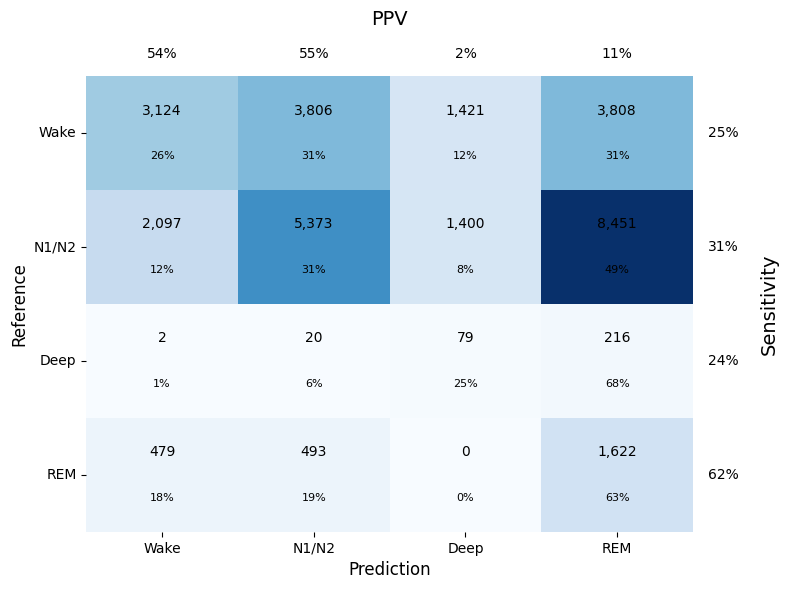

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/Baseline/cms/cm_model0.png
Done with loop 0


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_

Epoch 0: 100%|██████████| 101/101 [00:23<00:00,  4.37it/s, v_num=5w9l, train_loss_step=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:26<00:00,  3.87it/s, v_num=5w9l, train_loss_step=1.320, val_loss=1.350, val_acc=0.546, val_cohen_kappa=0.192, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.352


Epoch 1: 100%|██████████| 101/101 [00:23<00:00,  4.35it/s, v_num=5w9l, train_loss_step=1.540, val_loss=1.350, val_acc=0.546, val_cohen_kappa=0.192, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:23<00:00,  4.24it/s, v_num=5w9l, train_loss_step=1.330, val_loss=1.410, val_acc=0.293, val_cohen_kappa=0.0488, train_loss_epoch=1.330]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:27<00:00,  3.73it/s, v_num=5w9l, train_loss_step=1.330, val_loss=1.310, val_acc=0.335, val_cohen_kappa=0.109, train_loss_epoch=1.300] 

Metric val_loss improved by 0.045 >= min_delta = 0.0. New best score: 1.307


Epoch 3: 100%|██████████| 101/101 [00:24<00:00,  4.11it/s, v_num=5w9l, train_loss_step=1.340, val_loss=1.310, val_acc=0.335, val_cohen_kappa=0.109, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:27<00:00,  3.70it/s, v_num=5w9l, train_loss_step=1.340, val_loss=1.280, val_acc=0.329, val_cohen_kappa=0.118, train_loss_epoch=1.290]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 1.279


Epoch 4: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, v_num=5w9l, train_loss_step=1.520, val_loss=1.280, val_acc=0.329, val_cohen_kappa=0.118, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:23<00:00,  4.26it/s, v_num=5w9l, train_loss_step=1.410, val_loss=1.290, val_acc=0.356, val_cohen_kappa=0.126, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:25<00:00,  3.97it/s, v_num=5w9l, train_loss_step=1.200, val_loss=1.320, val_acc=0.365, val_cohen_kappa=0.127, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:24<00:00,  4.10it/s, v_num=5w9l, train_loss_step=1.190, val_loss=1.380, val_acc=0.335, val_cohen_kappa=0.118, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:27<00:00,  3.70it/s, v_num=5w9l, train_loss_step=1.190, val_loss=1.320, val_acc=0.339, val

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.279. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:27<00:00,  3.70it/s, v_num=5w9l, train_loss_step=1.190, val_loss=1.320, val_acc=0.339, val_cohen_kappa=0.140, train_loss_epoch=1.270]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇▇████████
train_loss_epoch,█▆▄▃▃▃▁▁
train_loss_step,▃▄▅▃▄█▃▃▄▃▃▂▄▄▂▂▅▄▃▃▃▁▂▃▃▅▄▃▃▂▂▁▃▂▂▃▄▄▂▃
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_acc,█▁▂▂▃▃▂▂
val_cohen_kappa,█▁▄▄▅▅▄▅
val_loss,▅█▃▁▂▃▇▃
epoch,7
train_loss_epoch,1.26515
train_loss_step,1.18615
trainer/global_step,807


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss/best-checkpoint-v13.ckpt
Trained model 1 in 218.78433871269226 seconds


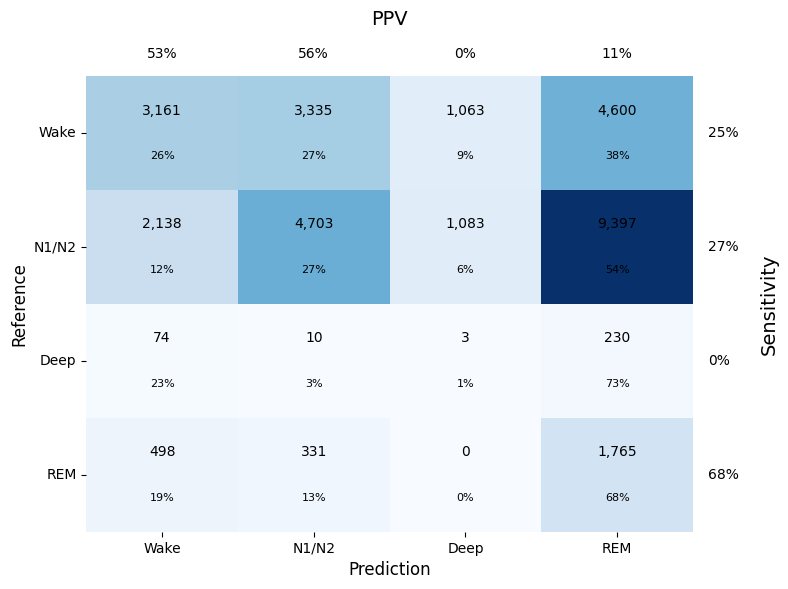

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/Baseline/cms/cm_model1.png
Done with loop 1


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_

Epoch 0: 100%|██████████| 101/101 [00:22<00:00,  4.54it/s, v_num=mihc, train_loss_step=1.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:25<00:00,  4.00it/s, v_num=mihc, train_loss_step=1.200, val_loss=1.360, val_acc=0.436, val_cohen_kappa=0.127, train_loss_epoch=1.350]

Metric val_loss improved. New best score: 1.360


Epoch 1: 100%|██████████| 101/101 [00:24<00:00,  4.15it/s, v_num=mihc, train_loss_step=1.250, val_loss=1.360, val_acc=0.436, val_cohen_kappa=0.127, train_loss_epoch=1.350]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:25<00:00,  3.92it/s, v_num=mihc, train_loss_step=1.390, val_loss=1.430, val_acc=0.379, val_cohen_kappa=0.108, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:28<00:00,  3.60it/s, v_num=mihc, train_loss_step=1.390, val_loss=1.340, val_acc=0.588, val_cohen_kappa=0.210, train_loss_epoch=1.320]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 1.344


Epoch 3: 100%|██████████| 101/101 [00:23<00:00,  4.32it/s, v_num=mihc, train_loss_step=1.330, val_loss=1.340, val_acc=0.588, val_cohen_kappa=0.210, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:24<00:00,  4.19it/s, v_num=mihc, train_loss_step=1.560, val_loss=1.370, val_acc=0.391, val_cohen_kappa=0.139, train_loss_epoch=1.300]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 101/101 [00:26<00:00,  3.76it/s, v_num=mihc, train_loss_step=1.560, val_loss=1.330, val_acc=0.300, val_cohen_kappa=0.0738, train_loss_epoch=1.280]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.329


Epoch 5: 100%|██████████| 101/101 [00:23<00:00,  4.21it/s, v_num=mihc, train_loss_step=1.250, val_loss=1.330, val_acc=0.300, val_cohen_kappa=0.0738, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:27<00:00,  3.73it/s, v_num=mihc, train_loss_step=1.250, val_loss=1.290, val_acc=0.299, val_cohen_kappa=0.108, train_loss_epoch=1.270] 

Metric val_loss improved by 0.043 >= min_delta = 0.0. New best score: 1.286


Epoch 6: 100%|██████████| 101/101 [00:24<00:00,  4.12it/s, v_num=mihc, train_loss_step=1.650, val_loss=1.290, val_acc=0.299, val_cohen_kappa=0.108, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:24<00:00,  4.09it/s, v_num=mihc, train_loss_step=1.120, val_loss=1.330, val_acc=0.309, val_cohen_kappa=0.0829, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:23<00:00,  4.21it/s, v_num=mihc, train_loss_step=1.290, val_loss=1.440, val_acc=0.388, val_cohen_kappa=0.125, train_loss_epoch=1.250] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 101/101 [00:26<00:00,  3.79it/s, v_num=mihc, train_loss_step=1.290, val_loss=1.280, val_acc=0.375, val_cohen_kappa=0.146, train_loss_epoch=1.240]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 1.277


Epoch 9: 100%|██████████| 101/101 [00:23<00:00,  4.34it/s, v_num=mihc, train_loss_step=1.110, val_loss=1.280, val_acc=0.375, val_cohen_kappa=0.146, train_loss_epoch=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 101/101 [00:24<00:00,  4.19it/s, v_num=mihc, train_loss_step=1.320, val_loss=1.280, val_acc=0.342, val_cohen_kappa=0.133, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 101/101 [00:25<00:00,  4.03it/s, v_num=mihc, train_loss_step=1.130, val_loss=1.350, val_acc=0.265, val_cohen_kappa=0.0819, train_loss_epoch=1.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:24<00:00,  4.13it/s, v_num=mihc, train_loss_step=0.981, val_loss=1.420, val_acc=0.357, val_cohen_kappa=0.112, train_loss_epoch=1.220] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 101/101 [00:27<00:00,  3.70it/s, v_num=mihc, train_loss_step=0.981, val_loss=1.250, val_acc=0.41

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.250


Epoch 13: 100%|██████████| 101/101 [00:23<00:00,  4.27it/s, v_num=mihc, train_loss_step=1.190, val_loss=1.250, val_acc=0.417, val_cohen_kappa=0.160, train_loss_epoch=1.230]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 101/101 [00:24<00:00,  4.18it/s, v_num=mihc, train_loss_step=1.630, val_loss=1.270, val_acc=0.339, val_cohen_kappa=0.140, train_loss_epoch=1.210]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|██████████| 101/101 [00:24<00:00,  4.20it/s, v_num=mihc, train_loss_step=1.110, val_loss=1.310, val_acc=0.315, val_cohen_kappa=0.143, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 101/101 [00:24<00:00,  4.07it/s, v_num=mihc, train_loss_step=1.020, val_loss=1.290, val_acc=0.401, val_cohen_kappa=0.147, train_loss_epoch=1.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|██████████| 101/101 [00:27<00:00,  3.67it/s, v_num=mihc, train_loss_step=1.020, val_loss=1.230, val_acc=0.450

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.234


Epoch 17: 100%|██████████| 101/101 [00:24<00:00,  4.20it/s, v_num=mihc, train_loss_step=1.630, val_loss=1.230, val_acc=0.450, val_cohen_kappa=0.205, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|██████████| 101/101 [00:26<00:00,  3.83it/s, v_num=mihc, train_loss_step=1.630, val_loss=1.190, val_acc=0.417, val_cohen_kappa=0.208, train_loss_epoch=1.140]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.190


Epoch 18: 100%|██████████| 101/101 [00:23<00:00,  4.38it/s, v_num=mihc, train_loss_step=1.230, val_loss=1.190, val_acc=0.417, val_cohen_kappa=0.208, train_loss_epoch=1.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|██████████| 101/101 [00:18<00:00,  5.38it/s, v_num=mihc, train_loss_step=1.020, val_loss=1.250, val_acc=0.416, val_cohen_kappa=0.204, train_loss_epoch=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|██████████| 101/101 [00:19<00:00,  5.14it/s, v_num=mihc, train_loss_step=1.110, val_loss=1.240, val_acc=0.438, val_cohen_kappa=0.201, train_loss_epoch=1.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 101/101 [00:19<00:00,  5.13it/s, v_num=mihc, train_loss_step=0.904, val_loss=1.260, val_acc=0.432, val_cohen_kappa=0.206, train_loss_epoch=1.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|██████████| 101/101 [00:22<00:00,  4.51it/s, v_num=mihc, train_loss_step=0.904, val_loss=1.220, val_acc=0.382

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.190. Signaling Trainer to stop.


Epoch 21: 100%|██████████| 101/101 [00:22<00:00,  4.51it/s, v_num=mihc, train_loss_step=0.904, val_loss=1.220, val_acc=0.382, val_cohen_kappa=0.174, train_loss_epoch=1.060]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████
train_loss_epoch,█▇▇▇▆▆▇▆▅▅▅▅▅▅▄▄▃▃▂▃▂▁
train_loss_step,▆▅▆▅▅▅▃▅▆█▄▅█▇▄▅▅▂▅▄▅▆▄▄▅▆▃▃▃▃▄▄▂▁▃▃▂▅▄▆
trainer/global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
val_acc,▅▃█▄▂▂▂▄▃▃▁▃▄▃▂▄▅▄▄▅▅▄
val_cohen_kappa,▄▃█▄▁▃▁▄▅▄▁▃▅▄▅▅█████▆
val_loss,▆█▅▆▅▄▅█▃▄▅▇▃▃▄▄▂▁▃▂▃▂
epoch,21
train_loss_epoch,1.05679
train_loss_step,0.9036
trainer/global_step,2221


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss/best-checkpoint-v14.ckpt
Trained model 2 in 582.4949440956116 seconds


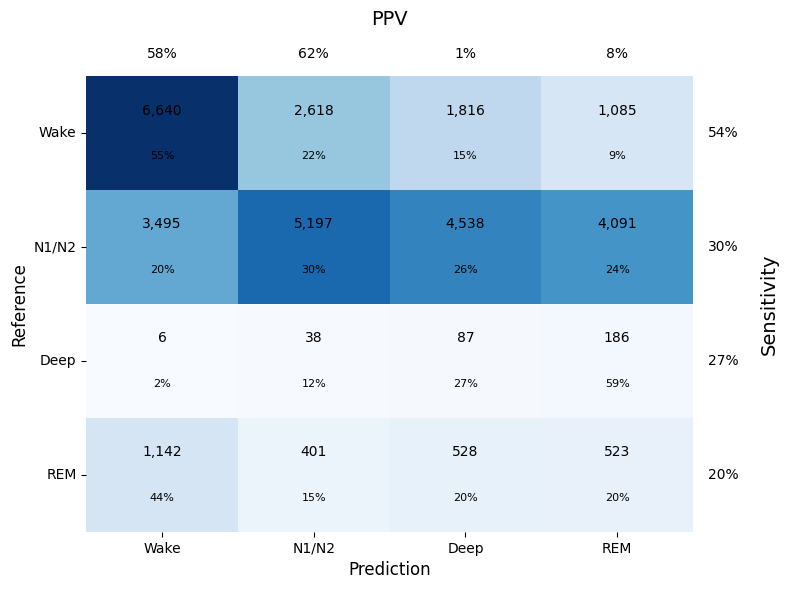

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/Baseline/cms/cm_model2.png
Done with loop 2


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_

Epoch 0: 100%|██████████| 101/101 [00:17<00:00,  5.66it/s, v_num=7kiv, train_loss_step=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:20<00:00,  5.04it/s, v_num=7kiv, train_loss_step=1.370, val_loss=1.460, val_acc=0.468, val_cohen_kappa=0.078, train_loss_epoch=1.370]

Metric val_loss improved. New best score: 1.464


Epoch 1: 100%|██████████| 101/101 [00:18<00:00,  5.36it/s, v_num=7kiv, train_loss_step=1.260, val_loss=1.460, val_acc=0.468, val_cohen_kappa=0.078, train_loss_epoch=1.370]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:19<00:00,  5.23it/s, v_num=7kiv, train_loss_step=1.330, val_loss=1.500, val_acc=0.354, val_cohen_kappa=0.0876, train_loss_epoch=1.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 101/101 [00:21<00:00,  4.67it/s, v_num=7kiv, train_loss_step=1.330, val_loss=1.340, val_acc=0.466, val_cohen_kappa=0.102, train_loss_epoch=1.320] 

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 1.345


Epoch 3: 100%|██████████| 101/101 [00:18<00:00,  5.44it/s, v_num=7kiv, train_loss_step=1.340, val_loss=1.340, val_acc=0.466, val_cohen_kappa=0.102, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:20<00:00,  4.85it/s, v_num=7kiv, train_loss_step=1.340, val_loss=1.290, val_acc=0.343, val_cohen_kappa=0.113, train_loss_epoch=1.310]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 1.293


Epoch 4: 100%|██████████| 101/101 [00:20<00:00,  5.03it/s, v_num=7kiv, train_loss_step=1.090, val_loss=1.290, val_acc=0.343, val_cohen_kappa=0.113, train_loss_epoch=1.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:19<00:00,  5.27it/s, v_num=7kiv, train_loss_step=1.440, val_loss=1.330, val_acc=0.269, val_cohen_kappa=0.0832, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 101/101 [00:19<00:00,  5.11it/s, v_num=7kiv, train_loss_step=1.240, val_loss=1.300, val_acc=0.389, val_cohen_kappa=0.147, train_loss_epoch=1.280] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:19<00:00,  5.17it/s, v_num=7kiv, train_loss_step=1.200, val_loss=1.310, val_acc=0.310, val_cohen_kappa=0.115, train_loss_epoch=1.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 101/101 [00:22<00:00,  4.57it/s, v_num=7kiv, train_loss_step=1.200, val_loss=1.320, val_acc=0.317, v

Monitored metric val_loss did not improve in the last 4 records. Best score: 1.293. Signaling Trainer to stop.


Epoch 7: 100%|██████████| 101/101 [00:22<00:00,  4.57it/s, v_num=7kiv, train_loss_step=1.200, val_loss=1.320, val_acc=0.317, val_cohen_kappa=0.104, train_loss_epoch=1.280]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███████
train_loss_epoch,█▆▅▄▁▂▁▂
train_loss_step,█▄▄▄▄▄▃▄▄▅▄▄▃▃▆▄▅▃▄▃▄▅▄▂▄▃▃▄▃▃▄▁▃▆▅▃▃▃▃▃
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇██
val_acc,█▄█▄▁▅▂▃
val_cohen_kappa,▁▂▃▅▂█▅▄
val_loss,▇█▃▁▂▁▂▂
epoch,7
train_loss_epoch,1.28331
train_loss_step,1.20279
trainer/global_step,807


Best model path: /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss/best-checkpoint-v15.ckpt
Trained model 3 in 175.1637794971466 seconds


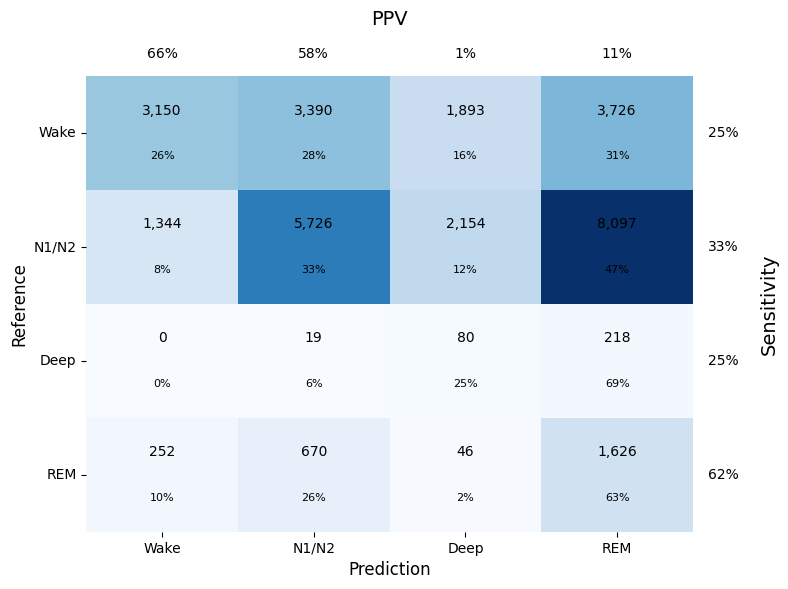

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Figure saved to /home/npr264/DeepLearning/project/cleaned/figures/Baseline/cms/cm_model3.png
Done with loop 3


/ext3/miniforge3/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /scratch/npr264/BioDeepL/project/checkpoints/Baseline/loss exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ext3/miniforge3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | embeddingLayer  | Linear               | 48     | train
1 | dropout_embed   | Dropout              | 0      | train
2 | dropout_hidden2 | Dropout              | 0      | train
3 | rnn             | LSTM                 | 8.5 M  | train
4 | hidden2         | Linear               | 32.8 K | train
5 | classifier      | Linear               | 132    | train
6 | train_criterion | CrossEntropyLoss     | 0      | train
7 | val_

Epoch 0: 100%|██████████| 101/101 [00:16<00:00,  6.02it/s, v_num=0e5u, train_loss_step=1.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 101/101 [00:18<00:00,  5.32it/s, v_num=0e5u, train_loss_step=1.100, val_loss=1.330, val_acc=0.295, val_cohen_kappa=0.0497, train_loss_epoch=1.360]

Metric val_loss improved. New best score: 1.330


Epoch 1: 100%|██████████| 101/101 [00:18<00:00,  5.45it/s, v_num=0e5u, train_loss_step=1.310, val_loss=1.330, val_acc=0.295, val_cohen_kappa=0.0497, train_loss_epoch=1.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 101/101 [00:20<00:00,  4.83it/s, v_num=0e5u, train_loss_step=1.310, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.0833, train_loss_epoch=1.320]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.293


Epoch 2: 100%|██████████| 101/101 [00:18<00:00,  5.33it/s, v_num=0e5u, train_loss_step=1.250, val_loss=1.290, val_acc=0.311, val_cohen_kappa=0.0833, train_loss_epoch=1.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:19<00:00,  5.18it/s, v_num=0e5u, train_loss_step=1.420, val_loss=1.310, val_acc=0.493, val_cohen_kappa=0.144, train_loss_epoch=1.300] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 101/101 [00:21<00:00,  4.64it/s, v_num=0e5u, train_loss_step=1.420, val_loss=1.270, val_acc=0.332, val_cohen_kappa=0.101, train_loss_epoch=1.290]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.266


Epoch 4: 100%|██████████| 101/101 [00:18<00:00,  5.35it/s, v_num=0e5u, train_loss_step=1.260, val_loss=1.270, val_acc=0.332, val_cohen_kappa=0.101, train_loss_epoch=1.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 101/101 [00:18<00:00,  5.40it/s, v_num=0e5u, train_loss_step=1.420, val_loss=1.340, val_acc=0.463, val_cohen_kappa=0.115, train_loss_epoch=1.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6:  83%|████████▎ | 84/101 [00:16<00:03,  5.16it/s, v_num=0e5u, train_loss_step=1.200, val_loss=1.270, val_acc=0.293, val_cohen_kappa=0.0925, train_loss_epoch=1.290] 

In [ ]:
accs = []
kappas = []
aurocs = []
cms = []
train_times = []
test_times = []
for i in range(10):
    model, train_time = train_model(
        batch_size = batch_size,
        dropout_embed = dropout_embed,
        acc_preprocess = acc_preprocess,
        RNN_type = RNN_type,
        lr = lr,
        rnn_hidden_size = rnn_hidden_size,
        pre_rnn_size = pre_rnn_size,
        hidden_size2 = hidden_size2,
        dropout_rnn = dropout_rnn,
        dropout_hidden2 = dropout_hidden2,
        modelType = modelType,
        nameAppend = f"model{i}")
    print(f"Trained model {i} in {train_time} seconds")
    acc, kappa, auroc, cm, inference_time_seconds = evaluate_model(model, test_loader, modelType, i)
    accs.append(acc)
    kappas.append(kappa)
    aurocs.append(auroc)
    cms.append(cms)
    train_times.append(train_time)
    test_times.append(inference_time_seconds)
    print(f"Done with loop {i}")

In [19]:
acc_mean, acc_std = np.mean(accs), np.std(accs)
kappa_mean, kappa_std = np.mean(kappas), np.std(kappas)
auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
train_time_mean, train_time_std = np.mean(train_times), np.std(train_times)
test_time_mean, test_time_std = np.mean(test_times), np.std(test_times)

# Print the statistics
print(f"Accuracy: Mean = {acc_mean:.3f}, StdDev = {acc_std:.3f}")
print(f"Kappa: Mean = {kappa_mean:.3f}, StdDev = {kappa_std:.3f}")
print(f"AUROC: Mean = {auroc_mean:.3f}, StdDev = {auroc_std:.3f}")

# Find the index of the best kappa
best_kappa_index = np.argmax(kappas)
print(f"Best Kappa Index: {best_kappa_index}")

# Find the index of the best acc
best_acc_index = np.argmax(accs)
print(f"Best Accuracy Index: {best_acc_index}")

# Find the index of the best AUROC
best_auroc_index = np.argmax(aurocs)
print(f"Best AUROC Index: {best_auroc_index}")

Accuracy: Mean = 0.319, StdDev = 0.045
Kappa: Mean = 0.085, StdDev = 0.026
AUROC: Mean = 0.544, StdDev = 0.031
Best Kappa Index: 2
Best Accuracy Index: 5
Best AUROC Index: 6
